In [13]:
import numpy as np
from cosmoTransitions import generic_potential_1
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special

####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
data = np.loadtxt( 'satoshi_dof.dat' )
Temperature_d=(data.T)[0][900:3900]
dof_d=(data.T)[1][900:3900]
#f = interpolate.interp1d(Temperature_d, dof_d)###"""the function works from T=[10e-4,1000]"""
g_star = interpolate.interp1d(Temperature_d, dof_d, kind='cubic')


class model1(generic_potential_1.generic_potential):
    def init(self, ms = 50, theta = 0, muhs = 0, u = 100, mu3 = 0):
        self.Ndim = 2
        self.renormScaleSq = v2
        self.ms = ms
        self.theta = theta
        self.muhs = muhs
        self.u = u
        self.mu3 = mu3
        self.lamh = 1/(4*v2)*(mh**2+self.ms**2 + (mh**2 - ms**2)*np.cos(2*self.theta))
        #self.lams = 1/(2*self.u**2)*(mh**2*np.sin(self.theta)**2+self.ms**2*np.cos(self.theta)**2 + self.mu3*self.u + self.muhs*v**2/(2*self.u))
        self.lams = 1/(4*self.u**3)*(mh**2*self.u + ms**2*self.u + 2*self.u**2*self.mu3 + v**2*self.muhs - (mh**2-ms**2)*self.u*np.cos(2*self.theta))
        self.lammix = 1/(v*self.u)*(-(self.ms**2-mh**2)*np.sin(self.theta)*np.cos(self.theta) - self.muhs*v)
        self.muh2 = self.lamh*v2 + self.muhs*self.u + self.lammix/2*self.u**2
        self.mus2 = -self.mu3*self.u + self.lams*self.u**2 + self.muhs*v2/(2*self.u) + self.lammix/2*v2

    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])
        #return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h, s = X[...,0], X[...,1]
        pot = -1/2*self.muh2*h**2 + 1/4*self.lamh*h**4 - 1/2*self.mus2*s**2 - 1/3*self.mu3*s**3 + 1/4*self.lams*s**4 + 1/2*self.muhs*h**2*s + 1/4*self.lammix*h**2*s**2
        return pot

    def boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

       #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)

        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B

        ####Gauge boson masses (Longitudinal)
        mWL = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZL=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,g**2*h**2/4,h**2/4*(g**2+g1**2),mWL,mZL])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,4,2 , 2,1]) ##Longitudinal at the end


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys

    def old_boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]


        #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)

        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B

        ####Gauge boson masses
        mW = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZ=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,mW,mZ])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,6,3])


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys


    def fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        mt=h**2/2
        M = np.array([mt])
        Mphys = np.array([v**2/2])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        dof = np.array([12])
        return M, dof, Mphys


    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.

        return [np.array([v,self.u])]

    def theory_consistent(self):
        perturbative_limit=4*np.pi
        perturbativity=self.lamh<=perturbative_limit and self.lams<=perturbative_limit and self.lammix<=perturbative_limit
        positivity=(self.lamh>0) and (self.lams>0) and (self.lammix>-2*(self.lamh*self.lams)**.5)
        if perturbativity and positivity:
            print("Model is theoretically consistent \n")
            return True
        else:
            print("Model is NOT theoretically consistent \n")
            return False


    def print_couplings(self):
        print("Potential parameters are given by \n ")
        print("mus2=",self.mus2, "muh2=",self.muh2,"lamh=",self.lamh,"lams=",self.lams,"lammix=",self.lammix,"\n")
        print("Model parameters are \n")
        print("ms=",self.ms,"theta=",self.theta,"muhs=",self.muhs,"u=",self.u,"mu3=",self.mu3,"\n")

    def isEWSB(self):
        """Method to find the deepest minima of the potential at T=0.
        Doesn't work for Z_2 symmetric potential!!!"""
        n=100
        X_EW=np.array([v,self.u])
        minima=[]
        if self.muhs==0 and self.mu3==0:
            print("Model has a Z2 symmetry in the potential \n")
            print("isEWSB=True \n")
            return True
        #------------
        X0=self.findMinimum([0,100],0)
        if self.Vtot(X0,0)<=self.Vtot(X_EW,0) and abs(abs(X0[0])-v)>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1:
            print("Global minimum found at X=",X0,"\n")
            print("isEWSB=False \n")
            return False
        X0=self.findMinimum([0,-100],0)
        if m.Vtot(X0,0)<=m.Vtot(X_EW,0) and abs(abs(X0[0])-v)>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1:
            print("Global minimum found at X=",X0,"\n")
            print("isEWSB=False \n")
            return False
         
        ###This loop search for a global minima randomly
        for i in range(n):
            x1=np.random.uniform(-100,4*self.Tmax)
            x2=np.random.uniform(-4*self.Tmax,4*self.Tmax)
            X0=self.findMinimum([x1,x2], T=0.0)
            if self.Vtot(X0,0)<=self.Vtot(X_EW,0) and abs(X0[0])-v>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1e2:
                print("Global minimum found at X=",X0,"\n")
                print("isEWSB=False \n")
                return False
        print("isEWSB=True \n")
        return True


#######HERE ARE MY OWN FUNCTIONS
#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS
#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS
#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTION
#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS
#######HERE ARE MY OWN FUNCTIONS


def alpha_GW(Tnuc,Drho):
    ####This code gives the parameter alpha relevant for stochastic GW spectrum
    ##AS APPEAR IN FORMULA (8.2) OF 1912.12634
    num_dof=g_star(Tnuc)
    radiationDensity=np.pi**2/30*num_dof*Tnuc**4
    latentHeat=Drho
    return latentHeat/radiationDensity



def trans_class(SymNR):
    """Classify the transition according to the following characteristics:
    ---------
    phi-sym: transition happens in the s-field direction
    phi-symNR: transition happens in the s-field direction (symmetry is not restored at T=1000)
    """
    SNR="sym"
    if SymNR==True:
        SNR="SNR"

    if dh>10 and ds>10:
        return "hs-"+SNR
    elif dh>10 and ds<1:
        return "h-"+SNR
    elif ds>10 and dh<1:
        return "s-"+SNR
    else:
        return "none"+SNR

    


def beta_GW(Tnuc,dS_TdT):
    ###This code defines the parameter beta relevant for stochastic GW spectrum
    num_dof=g_star(Tnuc)
    Hubble=np.sqrt(num_dof*np.pi**2/90)*Tnuc**2/Mplanck
    beta=Hubble*Tnuc*dS_TdT
    return beta/Hubble


def get_trans_index(allTrans):
    """Returns the index of the relevant transition"""
    #allTrans=m.TnTrans
    Num_Trans=len(m.TnTrans)
    if Num_Trans==0:
        print("No transitions were found")
        return 
    else:
        indx=Num_Trans-1
        for Trans in allTrans[::-1]:
            if Trans["trantype"]==1 and (np.sum((abs(Trans["high_vev"])-abs(Trans["low_vev"]))**2)**0.5)>=10:
                return indx
            else:
                indx-=1
                continue
    print("\n No relevant transition")      
    return None



In [14]:
##########HERE STARTS TRANSPORT EQUATIONS
##########HERE STARTS TRANSPORT EQUATIONS
##########HERE STARTS TRANSPORT EQUATIONS
##########HERE STARTS TRANSPORT EQUATIONS
def c_dist(x,m,n,p):
    """
    From 2007.10935, formula (8).
    Integrates the derivative of the Bose-Einstein or Fermi-Dirac distribution
    in the fluid frame (vw=0) and weighted by momentum^n/energy^m.  

    Parameters
    ----------
    x : float (mass divided by temperature)
    m: integer, power of energy in denominator
    n: integer, power of momenta in numerator
    p: integer /p=0 for Bosons and p=1 for Fermions
    
    Returns
    -------
    float, the result of integration
    """
    if (n%2)==0:
        integ=integrate.quad(lambda ee: \
                             (ee**2-x**2)**((n+1)/2)/ee**(m-1)*np.e**(-ee)/(1-(-1)**p*np.e**(-ee))**2,\
                             x, np.inf)
        integ_1=1/(4*np.pi**2)*(2/(1+n))*integ[0]
        return integ_1
    else:
        return 0
    


def d_dist(x,m,n,p):
    """
    From 2007.10935, formula (8).
    Integrates the Bose-Einstein or Fermi-Dirac distribution
    weighted by momentum^n/energy^m.  

    Parameters
    ----------
    x : float (mass divided by temperature)
    m: integer 
    n: integer 
    p: integer /p=0 for Bosons and p=1 for Fermions
    
    Returns
    -------
    float, the result of integration
    """
    if (n%2)==0:
        integ=integrate.quad(lambda ee: \
                             (ee**2-x**2)**((n+1)/2)/ee**(m-1)*np.e**(-ee)/(1-(-1)**p*np.e**(-ee)),\
                             x, np.inf)
        integ_1=1/(4*np.pi**2)*(2/(1+n))*integ[0]
        return integ_1
    else:
        return 0

def A_matrix(vw,x,p):
    """
    This function defines the matrix of coefficients for the
    ODE, see eq. (7) of 2007.10935.  

    Parameters
    ----------
    vw : float (the bubble wall velocity)
    x : float (mass divided by temperature)
    p: integer| n=0 for Bosons and n=1 for Fermions
    
    Returns
    -------
    A: np.array| 3x3 matrix of coefficients.
    """
    gamma=1/(1-vw**2)**0.5
    row1=[gamma*vw*c_dist(x,0,0,p),gamma*vw*c_dist(x,-1,0,p),gamma*d_dist(x,0,0,p)]
    row2=[gamma**2*vw*(c_dist(x,-1,0,p)+c_dist(x,1,2,p)),gamma**2*vw*(c_dist(x,-2,0,p)+c_dist(x,0,2,p)),
          gamma**2*(d_dist(x,-1,0,p)+vw**2*d_dist(x,1,2,p))]
    row3=[gamma*vw**2*c_dist(x,0,0,p)+1/gamma**3*sum(vw**(2*n-2)*c_dist(x,2*n,2*n,p) for n in range(1, 12)),
          c_dist(x,1,2,p)/gamma**3+gamma*vw**2*c_dist(x,-1,0,p)+vw/gamma**3*sum(vw**(2*n-3)*c_dist(x,2*n-1,2*n,p) for n in range(2, 12)),
          gamma*vw*d_dist(x,0,0,p)]

              
    Amat=np.array([row1,row2,row3])
    return Amat


def A_fluid(h0,vw,Lh,z,T):
    """
    This function defines the FULL matrix of coefficients for the
    ODE, see eq. (15) of 2007.10935.  

    Parameters
    ----------
    vw : float (the bubble wall velocity)
    z : float (direction transverse to the wall)
    T: float (Temperature)
    
    Returns
    -------
    A: np.array| 6x6 matrix of coefficients.
    """
    xw=(h_profile(z,Lh,h0)**2/6*(3*g**2/2+g1**2))**0.5/T
    xt=h_profile(z,Lh,h0)/2**0.5/T
    A_fl1=np.concatenate((A_matrix(vw,xw,0),np.zeros((3,3))),axis=1)
    A_fl2=np.concatenate((np.zeros((3,3)),A_matrix(vw,xt,1)),axis=1)
    A_fl=np.concatenate((A_fl1,A_fl2),axis=0)
    return A_fl


def Gamma_W(vw,T):
    """
    This function defines the matrix coming from the collision
    term, see eq.(B6)

    Parameters
    ----------
    vw : float (the bubble wall velocity)
    T: float (Temperature)
    
    Returns
    -------
    Gamma: np.array| 3x3 matrix of coefficients.
    """
    gamma=1/(1-vw**2)**0.5
    G11=0.00239
    G21=0.00512*gamma
    G12=0.00512
    G22=0.0174*gamma
    G13=(4.10*vw-3.28*vw**2+5.51*vw**3-4.47*vw**4)*10**(-3)
    G23=gamma*(1.36*vw+0.610*vw**2-2.90*vw**3+1.36*vw**4)*10**(-2)
    G33=(2.42-1.33*vw**2+3.14*vw**3-2.43*vw**4)*10**(-3)
    G31=(1.18*vw+2.79*vw**2-5.31*vw**3+3.66*vw**4)*10**(-3)
    G32=(2.48*vw+6.27*vw**2-11.9*vw**3+8.12*vw**4)*10**(-3)
    
    return T*np.array([[G11,G12,G13],[G21,G22,G23],[G31,G32,G33]])


def Gamma_t(vw,T):
    """
    This function defines the matrix coming from the collision
    term, see eq.(B6)

    Parameters
    ----------
    vw : float (the bubble wall velocity)
    T: float (Temperature)
    
    Returns
    -------
    Gamza: np.array| 3x3 matrix of coefficients.
    """
    gamma=1/(1-vw**2)**0.5
    G11=0.00196
    G21=0.00445*gamma
    G12=0.00445
    G22=0.0177*gamma
    G13=(5.36*vw-4.49*vw**2+7.44*vw**3-5.90*vw**4)*10**(-3)
    G23=gamma*(1.67*vw+1.38*vw**2-5.46*vw**3+2.85*vw**4)*10**(-2)
    G33=(4.07-2.14*vw**2+4.76*vw**3-4.37*vw**4)*10**(-3)
    G31=(0.948*vw+2.38*vw**2-4.51*vw**3+3.07*vw**4)*10**(-3)
    G32=(2.26*vw+4.82*vw**2-9.32*vw**3+6.54*vw**4)*10**(-3)
    
    return T*np.array([[G11,G12,G13],[G21,G22,G23],[G31,G32,G33]])



def my_Gamma(h0,vw,Lh,z,T):
    """
    This function defines the FULL Gamma matrix of collision terms for the
    ODE, see eq. (16) of 2007.10935 and returns the multiplication of the inverse
    of A_fluid times Gamma.  

    Parameters
    ----------
    vw : float (the bubble wall velocity)
    z : ndarray (direction transverse to the wall)
    T: float (Temperature)
    
    Returns
        -------
    Gamma: np.array| 6x6 matrix, the multiplication of the inverse of A_fluid times Gamma
    
    """
    ####The following code defines the diagonal part of the gamma
    ## Matrix as defined in eq. (16)
    gam__diagupper=np.concatenate((Gamma_W(vw,T),np.zeros((3,3))),axis=1)
    gam__diaglower=np.concatenate((np.zeros((3,3)),Gamma_t(vw,T)),axis=1)
    gamma_diag=np.concatenate((gam__diagupper,gam__diaglower),axis=0)
    ###The following matrices correspond to projection matrices. Defined in the paper.
    P_1=np.array([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])
    P_2=np.array([[1.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,1.0]])
    P_3=np.array([[0.0,0.0,0.0],[1.0,0.0,0.0],[0.0,0.0,0.0]])
    ###The following matrices correspond to background collision terms
    Gamma_bgW=-9*Gamma_W(vw,T)
    Gamma_bgt=-12*Gamma_t(vw,T)
    ###The following matrices correspond to eqn. (11)
    Nb=19 #number of bosons
    Nf=78 #number of fermions
    Abg=Nb*A_matrix(vw,0,0)+Nf*A_matrix(vw,0,1)
    ###The following code defines the matrix written in eq. (13) 
    ## where the bottom right block of Abg is inverted and 
    # the rest of the matrix elements are zero
    Abg_inv=np.dot(np.dot(P_2,Abg),P_1)+P_3
    Abg_inv=np.linalg.inv(Abg_inv)-np.transpose(P_3)
    ####The following code defines the non-diagonal part of the gamma
    ## Matrix as defined in the second term of eq. (16)
    gam__nondiagupper=np.concatenate((np.dot(Abg_inv,Gamma_bgW),\
                                      np.dot(Abg_inv,Gamma_bgt)),axis=1)
    gam__nondiaglower=np.concatenate((np.dot(Abg_inv,Gamma_bgW),\
                                      np.dot(Abg_inv,Gamma_bgt)),axis=1)
    gamma_nondiag=np.concatenate((gam__nondiagupper,gam__nondiaglower),axis=0)
    ##We define the total gamma matrix below
    gamma_tot= np.array([(np.dot(np.linalg.inv(A_fluid(h0,vw,Lh,i,T)),gamma_diag)-gamma_nondiag) for i in z])
    return gamma_tot 


def source_A(h0,vw,Lh,z,T):
    """
    This function calculates the source term, see eq. (9) and multplies it by 
    the inverse of A_fluid from the left.
    
    Parameters
    ----------
    vw : float (the bubble wall velocity)
    z : ndarray (direction transverse to the wall)
    T: float (Temperature)
    
    Returns
    -------
    Gamma: np.array| 6x1 matrix, the multiplication of the inverse of A_fluid times S
        
    """
    wholesource=[]
    for i in z:
        gamma=1/(1-vw**2)**0.5
        xw=(h_profile(i,Lh,h0)**2/6*(3*g**2/2+g1**2))**0.5/T
        xt=h_profile(i,Lh,h0)/2**0.5/T
        mwprime=Dh_profile(i,Lh,h0)*(1/6*(3*g**2/2+g1**2))**0.5
        mtprime=Dh_profile(i,Lh,h0)/2**0.5
        Source=np.array([xw*mwprime*(c_dist(xw,1,0,0)),\
                         xw*mwprime*(gamma*c_dist(xw,0,0,0)),\
                         xw*mwprime*(vw*c_dist(xw,1,0,0)-1/gamma**2*sum(vw**(2*n-1)*c_dist(xw,2*n+1,2*n,0) for n in range(1, 12))),\
                         xt*mtprime*(c_dist(xt,1,0,1)),\
                         xt*mtprime*(gamma*c_dist(xt,0,0,1)),\
                         xt*mtprime*(vw*c_dist(xt,1,0,1)-1/gamma**2*sum(vw**(2*n-1)*c_dist(xt,2*n+1,2*n,1) for n in range(1, 12)))])
        Source*=vw*gamma/T
        wholesource.append(np.dot(np.linalg.inv(A_fluid(h0,vw,Lh,i,T)),Source))
    return np.array(wholesource)

def Tranport_eqs(z, q,damping,source):
    """
    This function defines the differential equation to be solved. 
    It corresponds to eq. (14)
    
    Parameters
    ----------
    z : ndarray, the size of the integration region
    q: array (6D), the value of the perturbations
    
    Returns
    -------
    dq/dz, array    
    """
    rows=[]
    #damping=inter_gamma_matrix
    #source=inter_source

    for i in range(6):
        elem=[]
        for j in range(6):
            elem.append(-damping[i][j](z)*q[j])
        rows.append(sum(elem)+source[i](z))
    rows=tuple(rows)
    return np.vstack(rows)
    
def bc(ya, yb):
    """
    This code defines the boundary conditions to be used by BVP
    """
    return np.array([ya[0],yb[0],ya[3],yb[3],ya[1], ya[4]])
    #return np.array([ya[0],yb[0],ya[3],yb[3],ya[1]-ya[2], ya[4]-ya[5]])

    #return np.array([ya[0],yb[0],ya[3],yb[3],ya[1]**2+ya[2]**2 ,ya[4]**2+ya[5]**2])


def background_eqs(vw,z,q,T,sol):
    """
    This function defines the differential equation to be solved. 
    It corresponds to eq. (12)
    
    Parameters
    ----------
    z : ndarray, the size of the integration region
    q: array (6D), the value of the perturbations
    
    Returns
    -------
    dq/dz, array    
    """
    Gamma_bgW=-9*Gamma_W(vw,T)
    Gamma_bgt=-12*Gamma_t(vw,T)
    Nb=20 #number of bosons
    Nf=78 #number of fermions
    Abg=Nb*A_matrix(vw,0,0)+Nf*A_matrix(vw,0,1)
    P_1=np.array([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])
    P_2=np.array([[1.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,1.0]])
    P_3=np.array([[0.0,0.0,0.0],[1.0,0.0,0.0],[0.0,0.0,0.0]])
    Abg_inv=np.dot(np.dot(P_2,Abg),P_1)+P_3
    Abg_inv=np.linalg.inv(Abg_inv)-np.transpose(P_3)
    At=np.dot(Abg_inv,Gamma_bgt)
    Aw=np.dot(Abg_inv,Gamma_bgW)
    qw=sol.sol(z)[0:3]
    qt=sol.sol(z)[3:6]
    output=-np.dot(At,qt)-np.dot(Aw,qw)
    return output[1:]
    
def bc_background(ya, yb):
    """
    This code defines the boundary conditions to be used by BVP
    """
    return np.array([ya[0], ya[1]])
    

def d_dist_v(x,vw,p):
    """
    Inegral of distribution function in the wall frame divided by pz. 
    Given by eq. (8) with m=0 and n=-1.
    
    Parameters
    ----------
    x : float (mass divided by temperature)
    p: integer /p=0 for Bosons and p=1 for Fermions
    
    Returns
     -------
    float, the result of integration
    """
    ff=lambda x,v,e:2*v*(e**2-x**2)**0.5 + 2*e*(1-v**2)*np.arctanh((e**2-x**2)**0.5/e/v) if (e**2-x**2)**0.5/e/v<1 \
    else 2*v*(e**2-x**2)**0.5 + 2*e*(1-v**2)*np.log((e**2-x**2)**0.5/e/v)
    integ=integrate.quad(lambda e: np.exp(-e)/(1-(-1)**p*np.exp(-e))*ff(x,vw,e), x, np.infty)
    return integ[0]/4/np.pi**2




######HERE STARTS HYDRODYNAMIC EQUATIONS FROM REF.1004.4187
########################
########################
##############################
##############################
##############
##3######3
############## MORE FORMULAS RELEVANT 
 ##############FOR HYDRODYNAMICS
 ############## OF THE TEMPERATURE

def Lorentz_mu(v1,v2):
    """Lorentz transformation. Usually to the fluid frame"""
    return (v1-v2)/(1-v1*v2)

def hydrodynamic_eq(xi,v):
    """Parametrizes the equation for the fluid velocity. 
    Given by eqn. (2.27) in 1004.4187"""
    gamma=lambda vv:1/(1-vv**2)**0.5
    dv_dxi = 2*v/xi*(gamma(v)**2*(1-v*xi)*(Lorentz_mu(xi,v)**2/cs**2-1))**(-1)
    return dv_dxi



def Tp_exp_equation(xi,v_fun):
    """This function is the inegrand of the hydrodynamic relation log(T)/T. """
    v=v_fun(xi)
    return -2*cs**2*v*(xi-v)/xi/((xi-v)**2-cs**2*(1-v*xi)**2)
    
def sol_detonation_odeint(xi,alpha_p):
    """This function solves the hydrodynamic eqns. for detonations.
    For detonation the fluid in front of the wall is at rest (for the fluid rest frame)"""
    vp=xi
    if vp<=cs:
        print("Not a detonation. Velocity too low. ")
        return 
    det=-12*vp**2+(-1-3*vp**2+3*alpha_p*(1-vp**2))**2
    if det<0:
        print("Negative determinant")
        return 
    vm=(1+3*vp**2-3*alpha_p*(1-vp**2))/6/vp
    vm1=vm-1/6/vp*(det)**(0.5)
    vm2=vm+1/6/vp*(det)**(0.5)
    ##" strong detonations (v− < cs−) are not consistent solutions of the fluid equations,"
    vm=max([vm1,vm2])  ##Always choose the maximum value. 
    if vm==cs:
        print("Jouguet detonation")
    ###Now solve it:
    v_init=Lorentz_mu(vp,vm)
    v_range=np.linspace(cs,vp)[::-1]
    solut=integrate.odeint(hydrodynamic_eq, v_init, v_range,tfirst=True)
    return np.vstack((v_range,solut.T))


    
    
def sol_deflagration_odeint(xi,alpha_p):
    """This function solves the hydrodynamic eqns. for deflagrations.
    For deflagration the fluid behind the wall is at rest (for the fluid rest frame)"""
    vm=xi
    det=-1/3+(1/6/vm+vm/2)**2+2*alpha_p/3+alpha_p**2
    if det<0:
        print("Negative determinant")
        return 
    vp=(1/6/vm+vm/2)/(1+alpha_p)
    vp1=vp-det**0.5/(1+alpha_p)
    vp2=vp+det**0.5/(1+alpha_p)
    ###Now solve it:
    v_init=Lorentz_mu(vm,vp1)
    v_range=np.linspace(vm,1)
    solut=integrate.odeint(hydrodynamic_eq,v_init, v_range,tfirst=True)
    return np.vstack((v_range,solut.T))



def sol_deflagration_solve_ivp(xi,alpha_p):
    """This function solves the hydrodynamic eqns. for deflagrations.
    For deflagration the fluid behind the wall is at rest (in the fluid rest frame)
    
    Parameters
    ----------------
    xi: fluid velocity, self-similar variable
    alpha_p: The strength of the phase transition.
    """
    if xi>cs:
        print("Velocity is supersonic. Not a deflagration")
        return 
    vm=xi
    det=-1/3+(1/6/vm+vm/2)**2+2*alpha_p/3+alpha_p**2
    if det<0:
        print("Negative determinant")
        return 
    vp=(1/6/vm+vm/2)/(1+alpha_p)
    vp1=vp-det**0.5/(1+alpha_p)
    vp2=vp+det**0.5/(1+alpha_p)
    ###Now solve it:
    v_init=Lorentz_mu(vm,vp1)
    v_range=(vm,1)
    def myevent(xi,v):
        """Position of the shock-front"""
        return Lorentz_mu(xi,v)*xi-cs**2
    myevent.terminal=True
    solut=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]),method="BDF",events=[myevent])
    return [solut.t,solut.y[0]]



def sol_detonations_solve_ivp(xi,alpha_p):
    """This function solves the hydrodynamic eqns. for detonations:
       BOTH strong detonations and hybrids.
    For strong detonations the fluid in front of the wall is at rest (for the fluid rest frame).
    Hybrids are Jouguet detonations v-=cs"""
    xi_Jouguet=((alpha_p*(2+3*alpha_p))**0.5+1)/(3**0.5*(1+alpha_p))
    if xi<cs:
        print("Not a detonation. Velocity too low. ")
        return 
    elif (xi<=xi_Jouguet) :
        print("The solution is a hybrid")
        vm=cs
        vp=(-(alpha_p*(2+3*alpha_p))**0.5+1)/(3**0.5*(1+alpha_p))
        ###solve detonation component
        v_init=Lorentz_mu(xi,cs)
        v_range=(xi+10e-5,cs)
        solut_low=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]))
        ###solve deflagration component
        v_init=Lorentz_mu(xi,vp)
        v_range=(xi,1)
        def myevent(xi,v):
            """Position of the shock-front"""
            return Lorentz_mu(xi,v)*xi-cs**2
        myevent.terminal=True
        solut_high=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]),method="BDF",events=[myevent])
        xi_range=solut_low.t[1:][::-1],solut_high.t
        v_range=solut_low.y[0][1:][::-1],solut_high.y[0]
        deton_solution=[np.concatenate(xi_range),np.concatenate(v_range)]
    elif xi>xi_Jouguet:
        vp=xi
        print("The solution is a strong detonation")
        vm=(1+3*vp**2-3*alpha_p*(1-vp**2))/6/vp
        det=-12*vp**2+(-1-3*vp**2+3*alpha_p*(1-vp**2))**2
        vm1=vm-1/6/vp*(det)**(0.5)
        vm2=vm+1/6/vp*(det)**(0.5)
        vm=max([vm1,vm2])  ##Always choose the maximum value. 
        print(vm)
        v_init=Lorentz_mu(vp,vm)
        v_range=(vp,cs)
        solut=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]),method="BDF")
        deton_solution=[solut.t,solut.y[0]]
    return deton_solution 


def plot_Temperature_Deflagration(vm,alpha_p):
    """This function makes a plot of the logT/T"""
    det=-1/3+(1/6/vm+vm/2)**2+2*alpha_p/3+alpha_p**2
    if det>0:
        vp1=(1/6/vm+vm/2)/(1+alpha_p)-det**0.5/(1+alpha_p)
        defla=sol_deflagration_solve_ivp(vm,alpha_p)
        xi_range=defla[0]
        v_fun_inter=interpolate.interp1d(xi_range,defla[1])
        logT_T=integrate.quad(Tp_exp_equation,xi_range[0],xi_range[-1],args=(v_fun_inter))[0]
        plt.plot(xi_range,[Tp_exp_equation(xi,v_fun_inter) for xi in xi_range])
        plt.xlabel("$\\xi$",size=15)
        plt.ylabel("$\\log{T}/T$",rotation=0,size=15)
        plt.title("$\\log{T}/T$")
        plt.show()
    
    

####FIELD PROFILES

def h_profile(z,Lh,h0):
    return h0/2*(np.tanh(z/Lh)+1)
def Dh_profile(z,Lh,h0):
    return h0/2/np.cosh(z/Lh)**2/Lh
def DDh_profile(z,Lh,h0):
    return -h0/Lh**2/np.cosh(z/Lh)**2*np.tanh(z/Lh)

def s_profile(z,Ls,delta,slow,shigh):
    """scalar singlet profile, naive estimate"""
    return -(shigh-slow)/2*np.tanh(z/Ls-delta) + (shigh + slow)/2
def Ds_profile(z,Ls,delta,slow,shigh):
    return -(shigh-slow)/2/np.cosh(z/Ls-delta)**2/Ls
def DDs_profile(z,Ls,delta,slow,shigh):
    return (shigh-slow)/np.cosh(z/Ls-delta)**2*np.tanh(z/Ls-delta)/Ls**2



In [15]:
class bubble():
    """
    This is a simple bubble class which is used to determine it properties
    """
    def __init__(self,model):
        """
        vw:            0<float<=1, chosen value of wall velocity
        model:         model1, is a model for which we know its phase history
        guess:      dict, initial guess for parameters
        T:             float, temperature
        All_Solutions: list, containing the dictionaries of solutions
        
        """
        self.m=model
        
        allTrans=m.TnTrans
        indx=get_trans_index(m.TnTrans)
        self.m.TnTrans=[m.TnTrans[indx]]
        
        self.T=self.m.TnTrans[-1]["Tnuc"]
        self.guess={}
        self.hydro_dict={}
        self.All_Solutions={}
        self.grid_data=[]
        
    def test_analytic_formula(self):
        """Test whether the analytic formula would yield v_{analytic}<=v_Jouguet.
        Returns: Boolean"""
        #----Estimate velocity from eqn. (8.1) of 2111.02393
        Tnuc=self.T
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"]) 
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        dV = self.m.Vtot(self.m.TnTrans[-1]['high_vev'],Tnuc)-self.m.Vtot(self.m.TnTrans[-1]['low_vev'],Tnuc)
        radiationDensity=np.pi**2/30*g_star(Tnuc)*Tnuc**4
        print("\n (dV/alpha rho_r)^0.5 =",(dV/alpha_N/radiationDensity)**0.5)
        print("xi_Jouguet=",xi_Jouguet)
        if (dV/alpha_N/radiationDensity)**0.5 <= xi_Jouguet:
            return True
        else:
            return False

    def initial_guess(self):
        """
        This method uses the phase history of model m and fits the solition solution to tanh(z) 
        ansatz to provide initial guesses
        """
        #----Estimate velocity from eqn. (8.1) of 2111.02393
        Tnuc=self.T
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"]) 
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        dV = self.m.Vtot(self.m.TnTrans[-1]['high_vev'],Tnuc)-self.m.Vtot(self.m.TnTrans[-1]['low_vev'],Tnuc)
        radiationDensity=np.pi**2/30*g_star(Tnuc)*Tnuc**4
        if (dV/alpha_N/radiationDensity)**0.5 <= xi_Jouguet:
            print("Initial v_w <= v_Jouguet ")
            vel=(dV/alpha_N/radiationDensity)**0.5
        else:
            print("Initial v_w > v_Jouguet ")
            vel=xi_Jouguet
        #------------
        self.guess["vw"]=vel
        gamma=1/(1-vel**2)**0.5   
        Lh=1/self.T
        Ls=Lh
        h0=self.m.TnTrans[-1]["low_vev"][0]
        #s0=self.m.TnTrans[-1]["high_vev"][1]
        shigh=self.m.TnTrans[-1]["high_vev"][1]
        slow=self.m.TnTrans[-1]["low_vev"][1]
        dh=0
        ds=0
        mystring="Random Speed, vw="+str(self.guess["vw"])+"\n"
        mystring+= "Lh =" + str(Lh)+", " + "dh="+str(dh) + ", " + "h0=" + str(h0)+"\n"
        mystring+= "Ls =" + str(Ls)+", " + "ds="+str(ds) + ", " + "shigh=" + str(shigh)+ ", " + "slow=" + str(slow)
        params_str=["Lh", "dh", "h0", "Ls", "ds", "shigh","slow"]
        params_val=[Lh, dh, h0,Ls, ds, shigh,slow]
        
        for i in range(len(params_str)):
            self.guess[params_str[i]]=params_val[i]
        print("The inital fitted guess is \n" )
        print(self.guess)
    
    def assign_deflagration(self):
        """This method includes the deflagration treatment for the variables vp,T+ if the guess
        satisfies the deflagration criteria. It MODIFIES the GUESS to these variables 
        by solving hydrodynamic equation for the temperature equation"""
        vm=self.guess["vw"]
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"])
        def alpha_p_method(alpha_p):
            """This funcion solve the temperature equation. It is used to find alphap"""
            defla=sol_deflagration_solve_ivp(vm,alpha_p)
            xi_range=defla[0]
            v_range=defla[1]
            ##velocity behind the shock-front
            vsm=(xi_range[-1]-v_range[-1])/(1-xi_range[-1]*v_range[-1])
            ###The ratio between the temperature behind the shock-front to the nucleation temperature
            Tratio=(3*(1-vsm**2)/(9*vsm**2-1))**(1/4)
            v_fun_inter=interpolate.interp1d(xi_range,v_range)
            ###The ratio between the temperature behind the shock-front to the temperature in fron of the wall
            logT_T=integrate.quad(Tp_exp_equation,xi_range[0],xi_range[-1],args=(v_fun_inter))[0]
            Tp=Tnuc*np.exp(abs(logT_T))*Tratio
            return alpha_p*Tp**4-alpha_N*Tnuc**4
        
        print("Finding alpha+ \n...........")
        alpha_p=optimize.root_scalar(alpha_p_method,bracket=(0,alpha_N)).root
        Tp=(alpha_N/alpha_p)**(1/4)*Tnuc
        det=-1/3+(1/6/vm+vm/2)**2+2*alpha_p/3+alpha_p**2
        vp=(1/6/vm+vm/2)/(1+alpha_p)-det**0.5/(1+alpha_p)
        defla=sol_deflagration_solve_ivp(vm,alpha_p)
        xi_shock=defla[0][-1]
        
        print("........\n Finding velocity and temperature in front of the wall:")
        print("v_+=%f"%vp + ",   T_+=%f"%Tp)
        return {"Type":"Deflagration","alpha_p":alpha_p,"vw":vm,"vm":vm,"vp":vp,"xi_s":xi_shock,"Tp/TN":Tp/Tnuc}
    

    def assign_detonation(self):
        """This method includes the detonation treatment for the variables vp,T+.
        It is only non-trivial for hybrids. 
        A lot of code in this method is repeated from 
        the wall_speed module."""
        xi=self.guess["vw"]
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"])
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        ## First Test if it is a strong detonation 
        if xi>xi_Jouguet:
            print("This is a strong detonation")
            vp=xi
            det=-12*vp**2+(-1-3*vp**2+3*alpha_N*(1-vp**2))**2
            if det<0:
                print("Negative determinant. \n........")
                return
            vm=1+3*vp**2-3*alpha_N+3*vp**2*alpha_N+det**0.5
            vm*=1/6/vp
            return {"Type":"Detonation","alpha_p":alpha_N,"vw":xi,"vm":vm,"vp":xi,"xi_s":0,"Tp/TN":1}
        
        elif (xi<=xi_Jouguet) :
            print("This is a Jouguet detonation")
            def alpha_p_method(alpha_p):
                vm=cs
                ### Calculate the Jouguet velocity
                vp=(-(alpha_p*(2+3*alpha_p))**0.5+1)/(3**0.5*(1+alpha_p))
                ###solve deflagration component
                v_init=Lorentz_mu(xi,vp)
                v_range=(xi,1)
                def myevent(xi,v):
                    """Position of the shock-front"""
                    return Lorentz_mu(xi,v)*xi-cs**2
                myevent.terminal=True
                defla=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]),method="BDF",events=[myevent])
                xi_range=defla.t
                v_range=defla.y[0] 
                ##velocity behind the shock-front
                vsm=(xi_range[-1]-v_range[-1])/(1-xi_range[-1]*v_range[-1])
                ###The ratio between the temperature behind the shock-front to the nucleation temperature
                Tratio=(3*(1-vsm**2)/(9*vsm**2-1))**(1/4)
                v_fun_inter=interpolate.interp1d(xi_range,v_range)
                ###The ratio between the temperature behind the shock-front to the temperature in front of the wall
                logT_T=integrate.quad(Tp_exp_equation,xi_range[0],xi_range[-1],args=(v_fun_inter))[0]
                Tp=Tnuc*np.exp(logT_T)*Tratio
                return alpha_p*Tp**4-alpha_N*Tnuc**4 
            print("Finding alpha+ \n...........")
            alpha_p=optimize.root_scalar(alpha_p_method,bracket=(0.001*alpha_N,alpha_N)).root
            print("alpha+ = %3f" %alpha_p)
            vp=(-(alpha_p*(2+3*alpha_p))**0.5+1)/(3**0.5*(1+alpha_p))
            v_init=Lorentz_mu(xi,vp)
            v_range=(xi,1)
            def myevent(xi,v):
                """Position of the shock-front"""
                return Lorentz_mu(xi,v)*xi-cs**2
            myevent.terminal=True
            print("integrating the deflagration component ")
            defla=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]),method="BDF",events=[myevent])
            xi_range=defla.t
            print("........\n Finding velocity and temperature in front of the wall:")
            print(" v+=%3f"%vp + ", T+=%3f"%(alpha_N**0.25/alpha_p**0.25*Tnuc))
            return {"Type":"Hybrid","alpha_p":alpha_p,"vw":xi,"vm":cs,"vp":vp,"xi_s":xi_range[-1],
                    "Tp/TN":alpha_N**0.25/alpha_p**0.25}


    def which_hydro_sol(self):
        """When called, this method classifies the bubble as either
        Detonation, Deflagration or a hybrid based on certain (weak?) conditions
        WORK IN PROGRESS!"""
        xi=self.guess["vw"]
        if xi>=cs:
            self.hydro_dict=self.assign_detonation()
            return self.hydro_dict
        else:
            print("This is a Deflagration  \n................")
            self.hydro_dict=self.assign_deflagration()
            return self.hydro_dict
    
    def init_h0_s0(self):
        """Finds the root of the potential gradient and modifies the profile amplitudes in 
        guess dict."""
        h0=self.guess["h0"]
        slow=self.guess["slow"]
        shigh=self.guess["shigh"]
        Tp=self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"]
        phi_high=self.m.findMinimum([0,shigh],Tp)         
        phi_low =self.m.findMinimum([h0,slow],Tp)
        #----------update parameters
        self.guess["h0"]=phi_low[0]
        self.guess["slow"]=phi_low[1]
        self.guess["shigh"]=phi_high[1]  
        print("init_h0_s0 WAS SUCCESSFUL \n UPDATING SCALAR SINGLET PARAMETERS \n......................")
        print("Updated profile amplitues found \n")
        print("h0=%3f"%phi_low[0] + ", slow=%3f"%phi_low[1] + ", shigh=%3f"%phi_high[1])
        print("guess dict has been updated   \n......................")
        print("New guess is given by: \n ...........")
        print(self.guess)
        return [phi_high,phi_low]        
                
    def init_h0_s0_old(self):
        """Finds the root of the potential gradient and modifies the profile amplitudes in 
        guess dict."""
        h0=self.guess["h0"]
        slow=self.guess["slow"]
        shigh=self.guess["shigh"]
        Tp=self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"]
        phi_high=self.m.findMinimum([0,shigh],Tp)         
        phi_low =self.m.findMinimum([h0,slow],Tp)
        if abs(phi_high[0])<1e-4 and phi_high[1]>=10 and phi_low[0]>=10 and phi_low[1]>=10:
            self.guess["h0"]=phi_low[0]
            self.guess["slow"]=phi_low[1]
            self.guess["shigh"]=phi_high[1]  
            print("init_h0_s0 WAS SUCCESSFUL \n UPDATING SCALAR SINGLET PARAMETERS \n......................")
            print("Updated profile amplitues found \n")
            print("h0=%3f"%phi_low[0] + ", slow=%3f"%phi_low[1] + ", shigh=%3f"%phi_high[1])
            print("guess dict has been updated   \n......................")
            print("New guess is given by: \n ...........")
            print(self.guess)
        else:
            print("init_h0_s0 WAS NOT SUCCESSFUL \n ...................... \n......................")   
            
        return [phi_high,phi_low]
        
    def sol_perturbations(self):
        """When called, this method takes self.guess and calculates solves the transport equations."""
        vw, Lh, dh, h0, Ls, ds, smin, smax=self.guess.values()
        vw=self.hydro_dict["vp"]
        self.T=self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"]
        print("Solving Boltzmann transport equations for vw="+str(vw)+", Lh="+str(Lh)+", T+="+str(self.T)+"\n.......")
        z_range = np.linspace(-10*Lh, 15*Lh, 100)
        print("Initializing interpolation for damping term $A^{-1}\Gamma$\n...........")
        ###This loop creates an interpolation function for the Gamma matrix.
        ##It will be used in the definition of the differential equation 
        inter_gamma_matrix=[]
        call_gamma=my_Gamma(h0,vw,Lh,z_range,self.T)
        for i in range(6):
            row=[]
            for j in range(6):
                y=call_gamma[:,i,j]
                inter=interpolate.interp1d(z_range,y)
                row.append(inter)
            print("...........")
            inter_gamma_matrix.append(row)
        ###This loop creates an interpolation function for the source term.
        print("Initializing interpolation for source term $A^{-1}S$\n...........")
        inter_source=[]
        call_source=source_A(h0,vw,Lh,z_range,self.T)
        for i in range(6):
            y=call_source[:,i]
            inter=interpolate.interp1d(z_range,y)
            inter_source.append(inter) 
        print("Interpolation finished succesfully \n..............")
        y0 = np.zeros((6, z_range.size))
        def fun(z,q):
            return Tranport_eqs(z, q,inter_gamma_matrix,inter_source)
        print("Solving transport equations for fluid perturbations \n.......")
        perturbations = integrate.solve_bvp(fun, bc,z_range, y0)
        y0_bkgnd = np.zeros((2, z_range.size))
        def fun_background(z,q):
            return background_eqs(vw,z,q,self.T,perturbations)
        print("Solving transport equations for background perturbations \n.......")
        background = integrate.solve_bvp(fun_background,bc_background, z_range, y0_bkgnd)
        print("Solution is complete and added to All_Solutions.  \n..............")
        ##This creates an interpolation function for d_dist_v which is badly behaved in certain cases
        inter_d_dist_v_bosons=interpolate.interp1d(np.linspace(0,20,10),[d_dist_v(i,vw,0) for i in np.linspace(0,20,10)])
        inter_d_dist_v_fermions=interpolate.interp1d(np.linspace(0,20,10),[d_dist_v(i,vw,1) for i in np.linspace(0,20,10)])
        self.T=self.m.TnTrans[-1]["Tnuc"]
        self.All_Solutions={"Parameters":{"vp":vw,"Lh":Lh,"dh":dh, "h0":h0, "Ls":Ls, "ds":ds, "smin":smin,"smax":smax},
                                   "Perturbations":perturbations,"Background":background,
                                   "inter_d_dist_v_bosons":inter_d_dist_v_bosons,
                                   "inter_d_dist_v_fermions":inter_d_dist_v_fermions}
        print("Interpolating function for D_v^{0,-1} has been added.")
        
    def F(self,z):
        """
        Friction acting on the wall. Given by last
        term on eq. (22) of 2102.12490. 
        Parameters
        ----------
        z: float, distance transverse to the wall
        h0: float, Higgs profile amplitude
        Returns
        -------
        float
        """
        Lh=self.All_Solutions["Parameters"]["Lh"]
        h0=self.All_Solutions["Parameters"]["h0"]
        mw=(h_profile(z,Lh,h0)**2/6*(3*g**2/2+g1**2))**0.5
        mt=h_profile(z,Lh,h0)/2**0.5
        mwprime=(1/6*(3*g**2/2+g1**2))**0.5
        mtprime=1/2**0.5
        wdof=9 #Bosons number of dof
        tdof=12 #Bosons number of dof
        Tp=self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"]
        
        inter_d_dist_v_bosons=self.All_Solutions["inter_d_dist_v_bosons"]
        inter_d_dist_v_fermions=self.All_Solutions["inter_d_dist_v_fermions"]
        
        q=self.All_Solutions["Perturbations"].sol(z)
        qb=self.All_Solutions["Background"].sol(z)
        
        Fw=c_dist(mw/Tp,1,0,0)*q[0]+c_dist(mw/Tp,0,0,0)*(q[1]+qb[0])
        Fw+=inter_d_dist_v_bosons(mw/Tp)*(q[2]+qb[1])
        Fw*=2*mw*mwprime*wdof/2*Tp**2
        Ft=c_dist(mt/Tp,1,0,1)*q[3]+c_dist(mt/Tp,0,0,1)*(q[4]+qb[0])
        Ft+=inter_d_dist_v_fermions(mt/Tp)*(q[5]+qb[1])
        Ft*=2*mt*mtprime*tdof/2*Tp**2
        return Fw+Ft
    def print_friction(self):
        Lh=self.All_Solutions["Parameters"]["Lh"]
        z_range=np.linspace(-10*Lh,10*Lh,200)
        h0=self.guess["h0"]
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        Friction=[Dh_profile(z,Lh,h0)*self.F(z)/Tnuc**5 for z in z_range]

        plt.plot(z_range/Lh,Friction,label="$v=$"+str(self.All_Solutions["Parameters"]["vp"]))
        plt.xlim(-1,3)
        plt.xlabel("z/L")
        plt.ylabel("$F/T_n^5$")
        plt.legend(loc="upper right")
        plt.title("Friction force F times h'/Tn^5")
        plt.show()
        

    def update_h0(self):
        """This method updates the higgs profile amplitde h0 in such a way that the Higgs EOM
        is satisfied deep inside the bubble.
        Modifies h0 in guess dict."""
        Lh=self.All_Solutions["Parameters"]["Lh"]
        slow=self.guess["slow"]  ###Deep inside the bubble 
        z_inf=15*Lh
        def EOM_h(h):
            EOM_H=m.gradV([h_profile(z_inf,Lh,h),slow], self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"] )[0]
            EOM_H+=self.F(z_inf)
            return EOM_H 
        new_h0 = optimize.root_scalar(EOM_h,x0=300,x1=400)
        ###SOMETIMES EOM_h has two non-zero roots. Which one is relevant in that case?
        if new_h0.converged==True:
            print("update_h0 WAS SUCCESSFUL \n UPDATING SCALAR SINGLET PARAMETERS \n......................")
            print("Modified Higgs amplitude profile h0=" +str(new_h0.root)+".\n")
            self.guess["h0"]=new_h0.root
            print("guess dict has been updated   \n......................")
            print("h0=%0.3f"%self.guess["h0"] )
            print("New guess is given by: \n ...........")
            print(self.guess)
        else:
            print("update_h0 WAS NOT SUCCESSFUL \n ...................... \n......................")   
            
        return new_h0

      
    def update_s0(self):
        """finds the amplitude of the scalar singlet profile deep inside the bubble. Finds the root of dV/ds at T+"""
        hlow=self.guess["h0"]###deep inside the bubble
        def dv_ds(s_val):
            return self.m.gradV([hlow,s_val],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])[1]
        s0_sol=optimize.root_scalar(dv_ds,x0=100,x1=300)
        print("Modified singlet amplitude profile s0=" +str(s0_sol.root)+".\n")
        self.guess["slow"]=s0_sol.root
        
    def update_Ls(self):
        """The scalar singlet action. Minimization of this action fixes
        Ls and ds. 
        It modifies the guess dict."""
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        z_range = np.linspace(-10*Lh, 15*Lh, 1000)
        def S_action(x):
            """This is the action as writtten in eq. (27) 2102.12490 """
            L=x[0]
            d=x[1]
            #s_profile(z,Ls,d,slow,shigh)
            Veff=lambda z: self.m.Vtot([h_profile(z,Lh,h0),s_profile(z,L,d,slow,shigh)],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])
            Veff_star=lambda z: self.m.Vtot([h_profile(z,Lh,h0),s_profile(z,Lh,0,slow,shigh)],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])
            Integ=integrate.quad(lambda z: Veff(z)-Veff_star(z), z_range[0], z_range[-1])
            Action= (shigh-slow)**2/6/L  + Integ[0]
            return Action
        
        def jac_S(x):
            L=x[0]
            d=x[1]
            dV_ds= lambda z: self.m.gradV([h_profile(z,Lh,h0),s_profile(z,L,d,slow,shigh)],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])[1]
            ds_dL = lambda z: -(shigh-slow)*z/2/L**2/np.cosh(z/L-d)**2
            ds_dd= lambda z: -1/2*(shigh-slow)/np.cosh(z/L-d)**2
            dAction_dL=integrate.quad(lambda z: dV_ds(z)*ds_dL(z), z_range[0], z_range[-1])
            dAction_dd=integrate.quad(lambda z: dV_ds(z)*ds_dd(z), z_range[0], z_range[-1])
            return np.array((-(shigh-slow)**2/6/L**2+dAction_dL[0],dAction_dd[0]))
        def hess_S(x):
            L=x[0]
            d=x[1]
            dV_ds= lambda z: self.m.gradV([h_profile(z,Lh,h0),s_profile(z,L,d,slow,shigh)],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])[1]
            d2V_d2s= lambda z: self.m.d2V([h_profile(z,Lh,h0),s_profile(z,L,d,slow,shigh)],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])[1,1]
            ds_dL = lambda z: -(shigh-slow)*z/2/L**2/np.cosh(z/L-d)**2
            ds_dd= lambda z: -1/2*(shigh-slow)/np.cosh(z/L-d)**2
            d2s_d2L=lambda z: (shigh-slow)*z/L**3/np.cosh(z/L-d)**2 - z**2*(shigh-slow)/L**4/np.cosh(z/L-d)**2*np.tanh(z/L-d)
            d2s_d2d=lambda z: -(shigh-slow)*np.tanh(z/L-d)/np.cosh(z/L-d)**2
            d2s_dLdd=lambda z: -(shigh-slow)*z*np.tanh(z/L-d)/L**2/np.cosh(z/L-d)**2
            
            z_mid=(z_range[:-1]+z_range[1:])/2
            d2Action_d2L =lambda z: d2V_d2s(z)*ds_dL(z)**2 + dV_ds(z)*d2s_d2L(z)
            d2Action_d2d=lambda z: d2V_d2s(z)*ds_dd(z)**2 + dV_ds(z)*d2s_d2d(z)
            dAction_dddL=lambda z: d2V_d2s(z)*ds_dd(z)*ds_dL(z) + dV_ds(z)*d2s_dLdd(z)
            
            integral_1=np.sum(np.array([d2Action_d2L(zet) for zet in z_mid])*(-z_range[:-1]+z_range[1:]))
            integral_2=np.sum(np.array([d2Action_d2d(zet) for zet in z_mid])*(-z_range[:-1]+z_range[1:]))
            integral_3=np.sum(np.array([dAction_dddL(zet) for zet in z_mid])*(-z_range[:-1]+z_range[1:]))
            
            #d2Action_d2L=integrate.quad(lambda z: d2V_d2s(z)*ds_dL(z)**2 + dV_ds(z)*d2s_d2L(z),z_range[0], z_range[-1])
            #d2Action_d2d=integrate.quad(lambda z: d2V_d2s(z)*ds_dd(z)**2 + dV_ds(z)*d2s_d2d(z),z_range[0],z_range[-1])
            #dAction_dddL=integrate.quad(lambda z: d2V_d2s(z)*ds_dd(z)*ds_dL(z) + dV_ds(z)*d2s_dLdd(z),z_range[0],z_range[-1])
            #return np.array((((shigh-slow)**2/3/L**3+d2Action_d2L[0],dAction_dddL[0]),(dAction_dddL[0],d2Action_d2d[0])))
            return np.array((((shigh-slow)**2/3/L**3+integral_1,integral_3),(integral_3,integral_2)))
        bnds = ((0, None), (None, None))
        #new_guess=optimize.minimize(S_action,x0=np.array([Ls,ds]),bounds=bnds,method="Powell")
        #new_guess=optimize.minimize(S_action,x0=np.array([Ls,ds]),method="trust-ncg",jac=jac_S,hess=hess_S,tol=10e-2)
        #new_guess=optimize.brute(S_action, bnds) 
        #minimum = optimize.fmin(S_action, x0=np.array([self.guess["Lh"],0]))
        new_guess=optimize.minimize(S_action,x0=np.array([self.guess["Lh"],0]),bounds=bnds) 
        #new_guess=optimize.minimize(S_action,x0=minimum, bounds=bnds) 
        if new_guess.success==True:
            print("update_Ls WAS SUCCESSFUL \n UPDATING SCALAR SINGLET PARAMETERS \n......................")
            self.guess["Ls"]=new_guess.x[0]
            self.guess["ds"]=new_guess.x[1]
            print("guess dict has been updated   \n......................")
            print("Ls=%0.3f"%self.guess["Ls"] +",  ds=%0.3f"%self.guess["ds"])
            print("New guess is given by: \n ...........")
            print(self.guess)
        else:
            print("update_Ls WAS NOT SUCCESSFUL \n ...................... \n......................")   
        return new_guess
    
    
    def Eh(self,z):
        """EOM for the Higgs multiplied by h'(z)"""
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        EOM_H=-DDh_profile(z,Lh,h0)
        EOM_H+=self.m.gradV([h_profile(z,Lh,h0),s_profile(z,Ls,ds,slow,shigh)], self.hydro_dict["Tp/TN"]*Tnuc)[0]
        EOM_H+=self.F(z)
        EOM_H*=Dh_profile(z,Lh,h0)
        return EOM_H/Tnuc**5
    
    def Moment_1(self):
        """First moment integral of Eh, defined in eq. (25). 
        Rescaled by temperature so output is dimensionless"""
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        Lh=self.All_Solutions["Parameters"]["Lh"]
        integ=integrate.quad(lambda z: self.Eh(z), -10*Lh, 15*Lh)
        self.All_Solutions["Moment 1"]=integ[0]*Tnuc
        return integ[0]*Tnuc
    
    def Moment_2(self):
        """First moment integral of Eh, defined in eq. (26).
        Output is dimensionless"""
        Lh=self.guess["Lh"]
        h0=self.guess["h0"]
        integ=integrate.quad(lambda z: self.Eh(z)*(2*h_profile(z,Lh,h0)-h0), -10*Lh, 15*Lh)
        #integ=integrate.quad(lambda z: self.Eh(z)*DDh_profile(z,Lh,h0)/Dh_profile(z,Lh,h0), -10*Lh, 15*Lh)
        self.All_Solutions["Moment 2"]=integ[0]
        return integ[0]
    
    def Es(self,z):
        """EOM for the singlet """
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        Tplus=self.hydro_dict["Tp/TN"]
        EOM_H=-DDs_profile(z,Ls,ds,slow,shigh)
        EOM_H+=self.m.gradV([h_profile(z,Lh,h0),s_profile(z,Ls,ds,slow,shigh)],Tplus)[1]
        return EOM_H/Tnuc**5
    
        
    def Moment_3(self):
        """Second moment for the singlet, Es*s'. 
        Rescaled by temperature so output is dimensionless"""
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        integ=integrate.quad(lambda z: self.Es(z)*Ds_profile(z,Ls,ds,slow,shigh), -10*Lh, 15*Lh)
        self.All_Solutions["Moment 3"]=integ[0]*Tnuc
        return integ[0]*Tnuc
    
    def Moment_4(self):
        """Second momment for the singlet E_s*s''
        Output is dimensionless"""
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        integ=integrate.quad(lambda z: self.Es(z)*DDs_profile(z,Ls,ds,slow,shigh), -10*Lh, 15*Lh)
        self.All_Solutions["Moment 4"]=integ[0]
        return integ[0]
    
     
    def vel_algorithm(self,v,L):
        """This method solves the transport equations and then calculates the 
        moments for some vw and Lh including hydrodynamic effects.  """
        self.guess["vw"]=v
        self.guess["Lh"]=L
        print("Hydrodynamics taken into acount")
        self.which_hydro_sol()
        self.sol_perturbations()
        M1=self.Moment_1()
        M2=self.Moment_2()
        print("Moments have been calculated")
        return [M1,M2]
    
    def my_print(self):
        """When called this method prints a plot for all perturbations
        as function of the distance z/L"""
        Lh=self.All_Solutions["Parameters"]["Lh"]
        vw=self.All_Solutions["Parameters"]["vp"]
        z_range_1=np.linspace(-10*Lh,15*Lh,300)
        q=self.All_Solutions["Perturbations"].sol(z_range_1)
        qb=self.All_Solutions["Background"].sol(z_range_1)
        plt.plot(z_range_1/Lh, q[0],"b",label="$\mu_W$")
        plt.plot(z_range_1/Lh, q[1], "b--",label="$\delta \\tau_W$")
        plt.plot(z_range_1/Lh, q[2] ,"b:",label="$u_W$")
        plt.plot(z_range_1/Lh, q[3],"r",label="$\mu_{top}$")
        plt.plot(z_range_1/Lh, q[4], "r--",label="$\delta \\tau_{top}$")
        plt.plot(z_range_1/Lh, q[5] ,"r:",label="$u_{top}$")
        plt.plot(z_range_1/Lh, qb[0],"k",label="$\\tau_{bg}$")
        plt.plot(z_range_1/Lh, qb[1], "k--",label="$u_{bg}$")
        #plt.xlim(-6,10)
        plt.xlabel("z/L")
        plt.ylabel("$\delta$")
        plt.title("$v_w$ =%0.3f"%vw+", "+" $L_h$ =%0.3f " %Lh)
        plt.legend(loc="upper left")
        plt.show()
       
    def print_friction(self):
        Lh=self.All_Solutions["Parameters"]["Lh"]
        z_range=np.linspace(-10*Lh,10*Lh,200)
        h0=self.guess["h0"]
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        Friction=[Dh_profile(z,Lh,h0)*self.F(z)/Tnuc**5 for z in z_range]

        plt.plot(z_range/Lh,Friction,label="$v=$"+str(self.All_Solutions["Parameters"]["vp"]))
        plt.xlim(-1,3)
        plt.xlabel("z/L")
        plt.ylabel("$F/T_n^5$")
        plt.legend(loc="upper right")
        plt.title("Friction force F times h'/Tn^5")
        plt.show()

    def print_contribs(self):
        """This method plots the different contributions to the Higgs EOM.
        Useful for code comparison with other researchers"""
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        z_range=np.linspace(-10*Lh,10*Lh,100)
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        plt.plot(z_range,[-DDh_profile(kk,Lh,h0)*Dh_profile(kk,Lh,h0)/Tnuc**4 for kk in z_range],label="-h'' h'")
        plt.plot(z_range,[self.F(kk)*Dh_profile(kk,Lh,h0)/Tnuc**4 for kk in z_range],label="$F h'$")
        plt.plot(z_range,[self.m.gradV([h_profile(kk,Lh,h0),s_profile(kk,Ls,ds,slow,shigh)], 
                                          self.hydro_dict["Tp/TN"]*Tnuc)[0]*Dh_profile(kk,Lh,h0)/Tnuc**4
                             for kk in z_range],label="$dV/dh h'$")
        plt.xlabel("z")
        #plt.ylabel("$F/T^5$")
        #plt.xlim(-0.2,0.3)
        plt.legend()
        plt.title("M1 = Eh h' ")
        plt.show()
        
        plt.plot(z_range,[-DDh_profile(kk,Lh,h0)*Dh_profile(kk,Lh,h0)*(2*h_profile(kk,Lh,h0) - h0)/Tnuc**4 for kk in z_range],label="-h'' h' (2h-h0) ")
        plt.plot(z_range,[self.F(kk)*Dh_profile(kk,Lh,h0)*(2*h_profile(kk,Lh,h0) - h0)/Tnuc**4 for kk in z_range],label="$F h' (2h-h0)$")
        plt.plot(z_range,[self.m.gradV([h_profile(kk,Lh,h0),s_profile(kk,Ls,ds,slow,shigh)], 
                                          self.hydro_dict["Tp/TN"]*Tnuc)[0]*Dh_profile(kk,Lh,h0)*(2*h_profile(kk,Lh,h0)-h0)/Tnuc**4
                             for kk in z_range],label="$dV/dh h' (2h-h0)$")
        plt.xlabel("z")
        #plt.ylabel("$F/T^5$")
        #plt.xlim(-0.2,0.3)
        plt.legend()
        plt.title("M2 = Eh h'(2h - h0)  ")
        plt.show()
    
        
        
        plt.plot(z_range,[-DDh_profile(kk,Lh,h0)*DDh_profile(kk,Lh,h0)/Tnuc**4 for kk in z_range],label="-h'' h'' ")
        plt.plot(z_range,[self.F(kk)*DDh_profile(kk,Lh,h0)/Tnuc**4 for kk in z_range],label="$F h''$")
        plt.plot(z_range,[self.m.gradV([h_profile(kk,Lh,h0),s_profile(kk,Ls,ds,slow,shigh)], 
                                          self.hydro_dict["Tp/TN"]*Tnuc)[0]*DDh_profile(kk,Lh,h0)/Tnuc**4
                             for kk in z_range],label="$dV/dh h''$")
        plt.xlabel("z")
        #plt.ylabel("$F/T^5$")
        #plt.xlim(-0.2,0.3)
        plt.legend()
        plt.title("M2 = Eh h'' ")
        plt.show()
    
    
    def hydro_print(self):
        """Generates a plot with hydrodynamic quantities as function of xi_w. 
        Similar to figure 6 of Eenergy Budget 1004.4187"""
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"])
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        vel_range=np.concatenate((np.linspace(0.1,xi_Jouguet-0.0003,10),np.linspace(xi_Jouguet+0.0003,0.9,10)))
        hydrodicts=[]
        for vel in vel_range:
            self.guess["vw"]=vel
            hydrodicts.append(self.which_hydro_sol())
        vel_vp=[x["vp"] for x in hydrodicts]
        plt.plot(vel_range,vel_vp,"k",label="$v_+$")
        alpha_ratio=[x["alpha_p"]/alpha_N for x in hydrodicts]
        plt.plot(vel_range,alpha_ratio,"b--",label="$\\alpha_+/\\alpha_N$")
        vm_list=[x["vm"] for x in hydrodicts]
        plt.plot(vel_range,vm_list,"k--",label="$v_-$")
        xi_S=[x["xi_s"] for x in hydrodicts]
        plt.plot(vel_range,xi_S,"k-.",label="$\\xi_{sh}$")
        plt.legend()
        plt.xlabel("$\\xi_w$",size=13)
        plt.ylabel("$v(\\xi)$",size=13)
        plt.show()
        
        
    def grid_scan(self,v_range,L_range):
        """Scans velocity and width and generates a list with the grid data.
         It stores the list in grid_sol list: [X,Y,M_1,_M2].
        Parameters
        -----------
        v_range/L_range: tuples, indicating the lower and upper bounds for the scan"""
        vel=self.guess["vw"]
        Lw=self.guess["Lh"]
        v_max=v_range[1]
        while v_max>1:
            print("Upper velocity limit is non physical")
            v_max-=0.1
        alpha_N=alpha_GW(self.m.TnTrans[-1]["Tnuc"],self.m.TnTrans[-1]["Delta_rho"])
        v_min=v_range[0]
        self.guess["vw"]=v_min
        self.which_hydro_sol()
        while self.hydro_dict["vp"]<0:
            print("calculated v+ is negative")
            self.guess["vw"]+=0.01
            self.which_hydro_sol()
            v_min=self.guess["vw"]
        while Lw<1/self.T:
            print("width is non WKB compliant LT<1")
            Lw+=0.05/self.T
            
        ##----For small alphas --Reduces velocity if the Higgs EOM is not satisfied deep inside.   
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        v_max=self.reduce_vel_init_h0_s0()
        if v_max<=xi_Jouguet and v_max>xi_Jouguet-0.03:
            bool_vel=self.vel_max()
            if bool_vel==True:
                v_max=xi_Jouguet-0.03  
            x=np.linspace(v_min,v_max,v_range[2])
        else:
            x=np.concatenate((np.linspace(v_min,xi_Jouguet-0.0003,v_range[2]//2+1),
                              np.linspace(xi_Jouguet+0.0003,v_max,v_range[2]//2)))
        #------------------------------------------------------

    
        y=np.linspace(L_range[0],L_range[1],L_range[2])
        XY=[]
        for i in x:
            elem=[]
            for j in y:
                elem.append([i,j])
            XY.append(elem)
        XY=np.array(XY)
        
        matrix_M1=[]
        matrix_M2=[]
        for i in range(len(XY)):
            rows_M1=[]
            rows_M2=[]
            for j in range(len(XY[i])):
                self.initial_guess()
                self.guess["vw"]=XY[i][j][0]
                self.guess["Lh"]=XY[i][j][1]
                self.which_hydro_sol()
                self.init_h0_s0()
                self.sol_perturbations()
                self.update_h0()
                self.update_Ls()
                self.sol_perturbations()
                moms=[self.Moment_1(),self.Moment_2()]
                rows_M1.append(moms[0])
                rows_M2.append(moms[1])
            matrix_M1.append(rows_M1)
            matrix_M2.append(rows_M2)
        self.guess["vw"]=vel
        self.guess["Lh"]=Lw
        X,Y=np.meshgrid(x,y)
        self.grid_data=[X,Y,np.array(matrix_M1).T,np.array(matrix_M2).T]
        return self.grid_data
    
    def find_min_grid(self):
        """FIND THE MINIMUM using the interpolated data from grid_data list"""
        X, Y, Z_1, Z_2=self.grid_data
        def my_fun(x):
            points = np.array( (X.flatten(), Y.flatten()) ).T
            vel,L=x
            M_1 = interpolate.griddata( points, Z_1.flatten(), (vel  ,L),method="linear" )
            M_2 = interpolate.griddata( points, Z_2.flatten(), (vel  ,L) ,method="linear")
            return (M_1)**2+(M_2)**2
        def my_fun_vec(x):
            points = np.array( (X.flatten(), Y.flatten()) ).T
            vel,L=x
            M_1 = interpolate.griddata( points, Z_1.flatten(), (vel  ,L),method="linear" )
            M_2 = interpolate.griddata( points, Z_2.flatten(), (vel  ,L) ,method="linear")
            return [M_1,M_2]
        def find_solution(n):
            """Finds a solution v,L. If it doesn't find a solution it returns the initial guess. 
            --------------------------------------------------
            n: int, number of initial guesses
            returns: tuple, [v,L]"""
            if n<=0:
                return 
            vel=np.linspace(X.min(),X.max(),n)
            Lw=np.random.uniform(Y.min(),Y.max(),n)
            minima=[]
            for i in range(n):
                x0=(vel[i],Lw[i])
                result = optimize.root(my_fun_vec,x0)
                if result.success==True:
                    minima.append(result)
            try:
                sols=np.array([ff.x for ff in minima]).T ##extracts the solutions
                min_vw_index=list(sols[0]).index(sols[0].min()) ##get index  of the slowest the solution
                the_solution=(sols.T)[min_vw_index]
                print("SOLUTION WAS FOUND WITH ROOT FINDER \n ...................\n ....... \n ........")
                print("The solution found is:")
                print("[vw,L] = " +str(the_solution))
                return the_solution
            except: 
                print("NO SOLUTION WAS FOUND WITH ROOT FINDER \n ...................\n ....... \n ........")
                print("Minimizing quadrature")
                bnds = [(X.min(), X.max()), (Y.min(),Y.max())]
                minima=[]
                for i in range(n):
                    x0=(vel[i],Lw[i])
                    res = optimize.minimize(my_fun, x0, bounds=bnds)
                    minima.append(res)
                    ###The following finds the minima with the smallest velocity       
                sols=np.array([ff.x for ff in minima]).T
                min_vw_index=list(sols[0]).index(sols[0].min())
                the_solution=(sols.T)[min_vw_index]
                print("[vw,L] = " +str(the_solution))
                return the_solution
        the_solution =find_solution(100)   
        self.guess["vw"]=the_solution[0]
        self.guess["Lh"]=the_solution[1]
        print("Finding full guess dict solution")
        vel=self.guess["vw"]
        Lw=self.guess["Lh"]
        self.initial_guess()
        self.guess["vw"]=vel
        self.guess["Lh"]=Lw
        self.which_hydro_sol()
        self.init_h0_s0()
        self.sol_perturbations()
        self.update_h0()
        self.update_Ls()
        moments=self.vel_algorithm(self.guess["vw"],self.guess["Lh"])
        tol=1e-4
        print("Moments calculated are:")
        print(moments)
        print("Sum squared of moments  are:")
        print(sum(np.array(moments)**2))
        if sum(np.array(moments)**2)<tol:
            print("Converged to the level of %5f"%tol)
            return True, self.guess, sum(np.array(moments)**2)
        else:
            print("Did not converge to the level of %5f"%tol)
            return False, self.guess, sum(np.array(moments)**2)

    def print_gridmap(self):
        alpha_N=alpha_GW(self.m.TnTrans[-1]["Tnuc"],self.m.TnTrans[-1]["Delta_rho"])
        X, Y, Z_1, Z_2=self.grid_data
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
        mycmap1 = plt.get_cmap('ocean')
        ax1.set_title('$M_1/T_n^4$',size=20)
        ax1.set_xlabel('$v_w$',size=20)
        ax1.set_ylabel('$L_h T_n$',size=20)
        cf1 = ax1.contourf(X,Y*self.T,Z_1,cmap=mycmap1)
        fig.colorbar(cf1, ax=ax1)
        ax1.scatter(self.guess["vw"],self.guess["Lh"]*self.T,c="r")
        mycmap2 = plt.get_cmap('ocean')
        ax2.set_title('$M_2/T_n^5$',size=20)
        ax2.set_xlabel('$v_w$',size=20)
        ax2.set_ylabel('$L_h T_n$',size=20)
        cf2 = ax2.contourf(X,Y*self.T,Z_2, cmap=mycmap2)
        fig.colorbar(cf2, ax=ax2)
        ax2.scatter(self.guess["vw"],self.guess["Lh"]*self.T,c="r")
        plt.show()

        print("alpha ="+str(self.hydro_dict["alpha_p"]) + ", alpha_N=" + str(alpha_N))  
    
    def vel_max(self):
        """Models with very low alphas do not satisfy the EOM deep inside the bubble for vw>v_Jouguet. 
        This method checks if this is true and returns a boolean setting a maxium vw. """
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"])
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        guess_out=dict(self.guess)
        self.initial_guess()
        self.guess["vw"]=xi_Jouguet
        self.which_hydro_sol()
        self.init_h0_s0()
        self.sol_perturbations()
        self.update_h0()
        h_test=self.guess["h0"]
        self.guess=guess_out
        if h_test<=0:
            print("\n update_h0 returns h0<0 at vw=v_Jouguet")
            return True
        else:
            return False
        
    def reduce_vel_init_h0_s0(self):
        alpha_N=alpha_GW(self.m.TnTrans[-1]["Tnuc"],self.m.TnTrans[-1]["Delta_rho"])
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        guess_out=dict(self.guess)
        self.initial_guess()
        vel=xi_Jouguet
        while True:
            self.initial_guess()
            self.guess["vw"]=vel
            self.which_hydro_sol()
            self.init_h0_s0()
            if (self.guess["h0"]==guess_out["h0"]) and self.guess["shigh"]==guess_out["shigh"] and (self.guess["slow"]==guess_out["slow"]):
                vel-=0.03
            else:
                break
        self.guess=guess_out
        return vel


In [19]:
def potential_plot( modi,df,clevs=50, myN =170, index_trans=0):
    """Contour plot of the potential given index of the model and the data frame"""
    m=model1(ms = df.iloc[modi].ms, theta =df.iloc[modi].theta, muhs = df.iloc[modi].muhs,
             u = df.iloc[modi].u, mu3 =df.iloc[modi].mu3)
    Temp=df.iloc[modi]["Tnuc_"+str(index_trans)]
    X_1=[df.iloc[modi]["h_low_"+str(index_trans)],df.iloc[modi]["s_low_"+str(index_trans)]]
    X_2=[df.iloc[modi]["h_high_"+str(index_trans)],df.iloc[modi]["s_high_"+str(index_trans)]]

    smax=max(df.iloc[modi]["s_high_"+str(index_trans)],df.iloc[modi]["s_low_"+str(index_trans)])
    smin=min(df.iloc[modi]["s_high_"+str(index_trans)],df.iloc[modi]["s_low_"+str(index_trans)])
    hmax=max(df.iloc[modi]["h_high_"+str(index_trans)],df.iloc[modi]["h_low_"+str(index_trans)])
    hmin=min(df.iloc[modi]["h_high_"+str(index_trans)],df.iloc[modi]["h_low_"+str(index_trans)])
    box=(hmin-10,hmax+15,smin-10,smax+10)

    xmin,xmax,ymin,ymax=box
    x=np.linspace(xmin,xmax,clevs)
    y=np.linspace(ymin,ymax,clevs)
    X,Y=np.meshgrid(x,y)
    Z_V=[]
    for i in x:
        Z_V_row=[]
        for j in y:
            Z_V_row.append([m.Vtot([i,j],Temp)])
        Z_V.append(Z_V_row)
    Z_V=np.array(Z_V).T[0]


    fig, ax1 = plt.subplots(1,1,figsize=(12,6))
    ax1.set_title("$V_{eff}(h,s, T=$%1.f"%Temp + "), "+"$\\alpha=$"+str(np.round(df.iloc[modi]["alpha_"+str(index_trans)],4)),size=20)
    ax1.set_xlabel('$h$',size=20)
    ax1.set_ylabel('$s$',size=20)
    cf1 = ax1.contourf(X,Y,Z_V,myN,cmap="RdGy")
    fig.colorbar(cf1, ax=ax1)
    ax1.scatter(X_1[0],X_1[1],s=100)
    ax1.scatter(X_2[0],X_2[1])
    plt.show()
    


Potential parameters are given by 
 
mus2= 119956.91901188034 muh2= -104821.50901334583 lamh= 0.36172234918613444 lams= 7.457705533636791 lammix= 0.7634261164077384 

Model parameters are 

ms= 805.1368765169432 theta= -0.21275033809222565 muhs= 689.0185846431477 u= -207.89755083799642 mu3= -601.5846155799742 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [ 246.19999459 -207.89755018] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...................................................................................
Tracing phase starting at x = [-4.45298300e-06 -1.68344153e+02] ; t = 117.483971155313
Tracing minimum down
traceMinimum t0 = 117.484
..........................
Tracing minimum up
traceMinimum t0 = 117.484
..............................................................................................................................................................................................................................................

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091266,   T_+=84.390561
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6980041574353918, 'Lh': 0.01186710993519769, 'dh': 0, 'h0': 230.82365086309858, 'Ls': 0.01186710993519769, 'ds': 0, 'shigh': -167.42341632618297, 'slow': -204.68424598789085}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6980041574353918, 'Lh': 0.01186710993519769, 'dh': 0, 'h0': 230.82365086309858, 'Ls': 0.01186710993519769, 'ds': 0, 'shigh': -167.42341632618297, 'slow': -204.68424598789085}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


alpha+ = 0.013003
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.477137, T+=102.730566
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6980041574353918, 'Lh': 0.01186710993519769, 'dh': 0, 'h0': 230.82365086309858, 'Ls': 0.01186710993519769, 'ds': 0, 'shigh': -167.42341632618297, 'slow': -204.68424598789085}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.014616
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.470682, T+=99.770005
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6980041574353918, 'Lh': 0.01186710993519769, 'dh': 0, 'h0': 230.82365086309858, 'Ls': 0.01186710993519769, 'ds': 0, 'shigh': -167.42341632618297, 'slow': -204.68424598789085}
This i

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.431229,   T_+=89.367687
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6980041574353918, 'Lh': 0.01186710993519769, 'dh': 0, 'h0': 230.82365086309858, 'Ls': 0.01186710993519769, 'ds': 0, 'shigh': -167.42341632618297, 'slow': -204.68424598789085}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.414898,   T_+=88.320054
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6980041574353918, 'Lh': 0.01186710993519769, 'dh': 0, 'h0': 230.82365086309858, 'Ls': 0.01186710993519769, 'ds': 0, 'shigh': -167.42341632618297, 'slow': -204.68424598789085}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and tem

........
 Finding velocity and temperature in front of the wall:
v_+=0.007869,   T_+=84.267585
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6980041574353918, 'Lh': 0.01186710993519769, 'dh': 0, 'h0': 230.82365086309858, 'Ls': 0.01186710993519769, 'ds': 0, 'shigh': -167.42341632618297, 'slow': -204.68424598789085}
This is a Deflagration  
................
Finding alpha+ 
...........
modi= -1  did not work
Potential parameters are given by 
 
mus2= 179359.43114194117 muh2= -93713.3134087421 lamh= 0.4192580766617184 lams= 7.737454721365794 lammix= -0.1193925395064806 

Model parameters are 

ms= 837.6274264386641 theta= 0.22843904250999536 muhs= -590.977240681148 u= 197.6299688090205 mu3= 144.71597443923636 

Model is theoretically consistent 



/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:364: RuntimeWarning: invalid value encountered in sqrt


isEWSB=True 

Tracing phase starting at x = [246.20000143 197.62996947] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
..................................................................................
Tracing phase starting at x = [-2.74804444e-07  1.56559970e+02] ; t = 117.53914658779655
Tracing minimum down
traceMinimum t0 = 117.539
..........................
Tracing minimum up
traceMinimum t0 = 117.539
.....................................................................................................................................................................................................................................................................................................................
Tunneling from phase 1 to phase 0 at T=0
high_vev = [1.86448253e-05 1.54409584e+02]
low_vev = [246.20000378 197.62996923]
Path deformation converged. 23 steps. fRatio = 1.35714e-02
Path deformation converged. 1 steps. fRatio = 5.45862e-02
Tunneling from phase 1 to phase 0 at T=

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091277,   T_+=84.410737
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6979378202891895, 'Lh': 0.011864252714861074, 'dh': 0, 'h0': 230.93596882319645, 'Ls': 0.011864252714861074, 'ds': 0, 'shigh': 155.62346502872532, 'slow': 194.207237397161}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6979378202891895, 'Lh': 0.011864252714861074, 'dh': 0, 'h0': 230.93596882319645, 'Ls': 0.011864252714861074, 'ds': 0, 'shigh': 155.62346502872532, 'slow': 194.207237397161}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


alpha+ = 0.012992
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.477182, T+=102.744632
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=211.894400, slow=189.981561, shigh=156.140985
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.6985461697797707, 'Lh': 0.011864252714861074, 'dh': 0, 'h0': 211.89439952195175, 'Ls': 0.011864252714861074, 'ds': 0, 'shigh': 156.14098500110234, 'slow': 189.98156092446752}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6979378202891895, 'Lh': 0.011864252714861074, 'dh': 0, 'h0': 230.93596882319645, 'Ls': 0.011864252714861074, 'ds': 0, 'shigh': 155.62346502872532, 'slow': 194.207237397161}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012992
integrating the deflagration component 
........
 Finding velocity and temperature in front 

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.010,  ds=0.302
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.011864252714861074, 'dh': 0, 'h0': 230.80852926997954, 'Ls': 0.010461932136516902, 'ds': 0.30216925641058867, 'shigh': 155.62681547706958, 'slow': 194.18765151340028}
Solving Boltzmann transport equations for vw=0.09127689014874596, Lh=0.011864252714861074, T+=84.41073660148211
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has be

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:383: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.047,  ds=0.248
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.04745701085944429, 'dh': 0, 'h0': 230.7862316448022, 'Ls': 0.04745700639063509, 'ds': 0.24782185075957774, 'shigh': 155.62681547706958, 'slow': 194.18765151340028}
Solving Boltzmann transport equations for vw=0.09127689014874596, Lh=0.04745701085944429, T+=84.41073660148211
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been a

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.269520,   T_+=85.353605
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=230.167665, slow=194.035848, shigh=155.652372
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.2995153899265902, 'Lh': 0.011864252714861074, 'dh': 0, 'h0': 230.16766489430142, 'Ls': 0.011864252714861074, 'ds': 0, 'shigh': 155.65237238536992, 'slow': 194.03584814928462}
Solving Boltzmann transport equations for vw=0.26952039580209697, Lh=0.011864252714861074, T+=85.35360515594316
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport eq

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6979378202891895, 'Lh': 0.011864252714861074, 'dh': 0, 'h0': 230.93596882319645, 'Ls': 0.011864252714861074, 'ds': 0, 'shigh': 155.62346502872532, 'slow': 194.207237397161}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.269520,   T_+=85.353605
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=230.167665, slow=194.035848, shigh=155.652372
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.2995153899265902, 'Lh': 0.11864252714861073, 'dh': 0, 'h0': 230.16766489430142, 'Ls': 0.011864252714861074, 'ds': 0, 'shigh': 155.65237238536992, 'slow': 194.03584814928462}
Solving Boltzmann transport equati

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6979378202891895, 'Lh': 0.011864252714861074, 'dh': 0, 'h0': 230.93596882319645, 'Ls': 0.011864252714861074, 'ds': 0, 'shigh': 155.62346502872532, 'slow': 194.207237397161}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.421003,   T_+=88.670221
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=227.578720, slow=193.458838, shigh=155.

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.011,  ds=0.327
New guess is given by: 
 ...........
{'vw': 0.6985461697797707, 'Lh': 0.011864252714861074, 'dh': 0, 'h0': 211.47447063839942, 'Ls': 0.010503356969392396, 'ds': 0.3273480442834726, 'shigh': 156.14098500110234, 'slow': 189.98156092446752}
Solving Boltzmann transport equations for vw=0.47718153466916763, Lh=0.011864252714861074, T+=102.7446315509163
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=211.7035389783761.

guess dict has been updated   
......................
h0=211.704
New guess is given by: 
 ...........
{'vw': 0.6985461697797707, 'Lh': 0.11864252714861073, 'dh': 0, 'h0': 211.7035389783761, 'Ls': 0.011864252714861074, 'ds': 0, 'shigh': 156.14098500110234, 'slow': 189.98156092446752}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.119,  ds=0.271
New guess is given by: 
 ...........
{'vw': 0.6985461697797707, 'Lh': 0.11864252714861073, 'dh': 0, 'h0': 211.7035389783761, 'Ls': 0.11864252108318053, 'ds': 0.27102800939259025, 'shigh': 156.14098500110234, 'slow': 189.98156092446752}
Solving Boltzmann transport equations for vw=0.47718153466

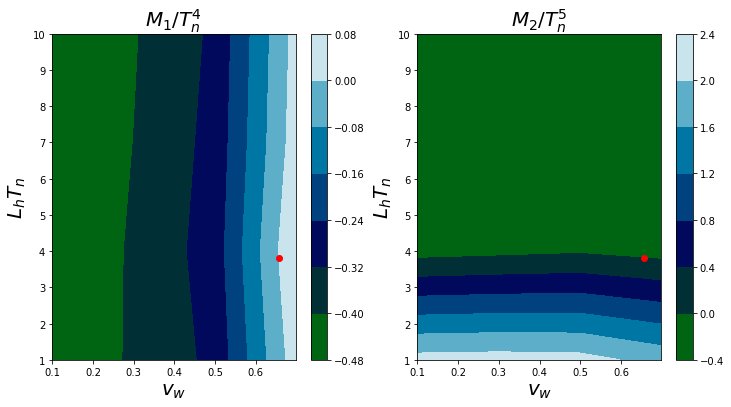

alpha =0.015247630110568901, alpha_N=0.0286865088498647


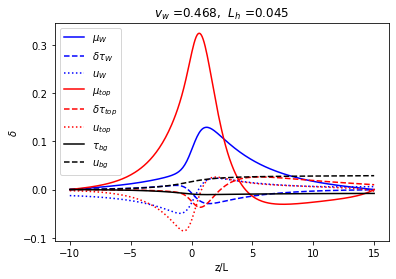

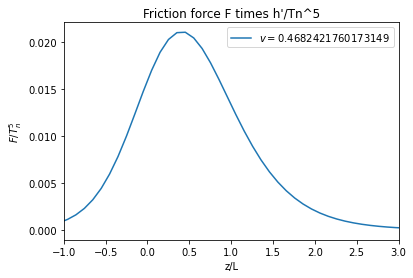

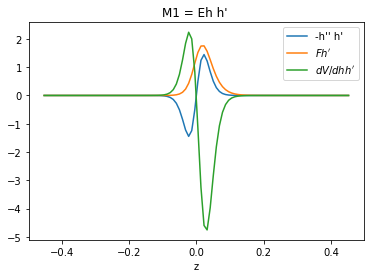

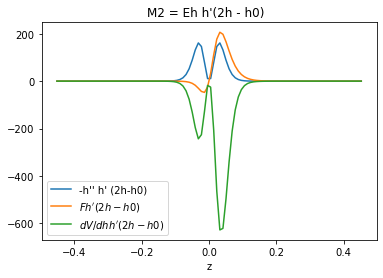

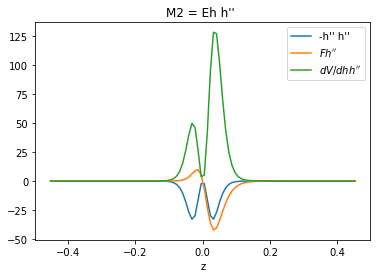

Potential parameters are given by 
 
mus2= 212834.04907700245 muh2= -98819.1870651589 lamh= 0.4744694229526897 lams= 8.577548142932484 lammix= -0.8105902492294361 

Model parameters are 

ms= 891.2098626801532 theta= 0.2340311520311195 muhs= -549.6377728556091 u= 202.0201757106041 mu3= 149.54116141464976 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [246.19999514 202.020174  ] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.........................................................................................
Tracing phase starting at x = [4.84557925e-06 1.61160141e+02] ; t = 117.57411789266213
Tracing minimum down
traceMinimum t0 = 117.574
............................
Tracing minimum up
traceMinimum t0 = 117.574
.............................................................................................................................................................................................................................................

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091305,   T_+=84.382586
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6969440116257616, 'Lh': 0.011868155351076477, 'dh': 0, 'h0': 231.03629423686215, 'Ls': 0.011868155351076477, 'ds': 0, 'shigh': 160.19826872049504, 'slow': 198.53791717166158}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6969440116257616, 'Lh': 0.011868155351076477, 'dh': 0, 'h0': 231.03629423686215, 'Ls': 0.011868155351076477, 'ds': 0, 'shigh': 160.19826872049504, 'slow': 198.53791717166158}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


alpha+ = 0.012964
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.477298, T+=102.682685
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=212.185425, slow=194.273567, shigh=160.720533
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.6983757305887548, 'Lh': 0.011868155351076477, 'dh': 0, 'h0': 212.1854245941471, 'Ls': 0.011868155351076477, 'ds': 0, 'shigh': 160.7205325106683, 'slow': 194.27356713776166}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6969440116257616, 'Lh': 0.011868155351076477, 'dh': 0, 'h0': 231.03629423686215, 'Ls': 0.011868155351076477, 'ds': 0, 'shigh': 160.19826872049504, 'slow': 198.53791717166158}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012964
integrating the deflagration component 
........
 Finding velocity and temperature in front 

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.010,  ds=0.321
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.011868155351076477, 'dh': 0, 'h0': 230.91451837887428, 'Ls': 0.010419750083772708, 'ds': 0.32096244174715866, 'shigh': 160.20161071681028, 'slow': 198.51810345917028}
Solving Boltzmann transport equations for vw=0.09130525768832354, Lh=0.011868155351076477, T+=84.38258596140649
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has be

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.101,  ds=0.334
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.11868155351076476, 'dh': 0, 'h0': 230.88419641361375, 'Ls': 0.1011498601681832, 'ds': 0.3335545316472389, 'shigh': 160.20161071681028, 'slow': 198.51810345917028}
Solving Boltzmann transport equations for vw=0.09130525768832354, Lh=0.11868155351076476, T+=84.38258596140649
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been ad

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.269563,   T_+=85.321558
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=230.276278, slow=198.364646, shigh=160.227012
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29945857686291827, 'Lh': 0.011868155351076477, 'dh': 0, 'h0': 230.27627845065592, 'Ls': 0.011868155351076477, 'ds': 0, 'shigh': 160.2270117985184, 'slow': 198.3646455346359}
Solving Boltzmann transport equations for vw=0.2695629263422892, Lh=0.011868155351076477, T+=85.32155766835331
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equa

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6969440116257616, 'Lh': 0.011868155351076477, 'dh': 0, 'h0': 231.03629423686215, 'Ls': 0.011868155351076477, 'ds': 0, 'shigh': 160.19826872049504, 'slow': 198.53791717166158}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.269563,   T_+=85.321558
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=230.276278, slow=198.364646, shigh=160.227012
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29945857686291827, 'Lh': 0.11868155351076476, 'dh': 0, 'h0': 230.27627845065592, 'Ls': 0.011868155351076477, 'ds': 0, 'shigh': 160.2270117985184, 'slow': 198.3646455346359}
Solving Boltzmann transport equat

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6969440116257616, 'Lh': 0.011868155351076477, 'dh': 0, 'h0': 231.03629423686215, 'Ls': 0.011868155351076477, 'ds': 0, 'shigh': 160.19826872049504, 'slow': 198.53791717166158}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.421119,   T_+=88.627904
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=227.713831, slow=197.781301, shigh=16

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.010,  ds=0.345
New guess is given by: 
 ...........
{'vw': 0.6983757305887548, 'Lh': 0.011868155351076477, 'dh': 0, 'h0': 211.8164035751022, 'Ls': 0.010452870764790376, 'ds': 0.34461007885430883, 'shigh': 160.7205325106683, 'slow': 194.27356713776166}
Solving Boltzmann transport equations for vw=0.47729799122856065, Lh=0.011868155351076477, T+=102.6826847131305
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=212.0176456178074.

guess dict has been updated   
......................
h0=212.018
New guess is given by: 
 ...........
{'vw': 0.6983757305887548, 'Lh': 0.11868155351076476, 'dh': 0, 'h0': 212.0176456178074, 'Ls': 0.011868155351076477, 'ds': 0, 'shigh': 160.7205325106683, 'slow': 194.27356713776166}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.101,  ds=0.357
New guess is given by: 
 ...........
{'vw': 0.6983757305887548, 'Lh': 0.11868155351076476, 'dh': 0, 'h0': 212.0176456178074, 'Ls': 0.10090164805769752, 'ds': 0.3570689793172244, 'shigh': 160.7205325106683, 'slow': 194.27356713776166}
Solving Boltzmann transport equations for vw=0.47729799122856

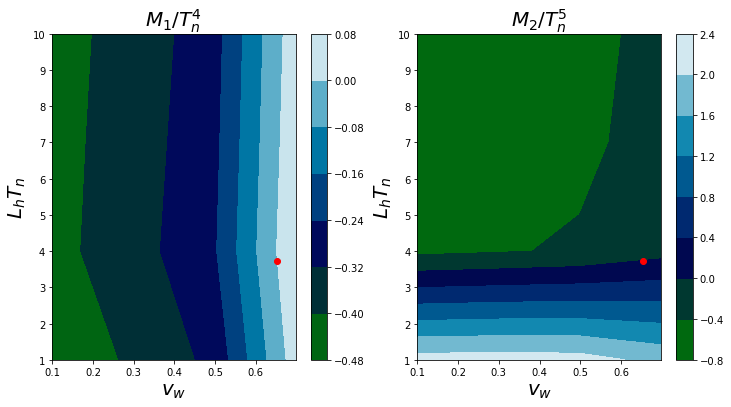

alpha =0.015387281479437449, alpha_N=0.028592585986988606


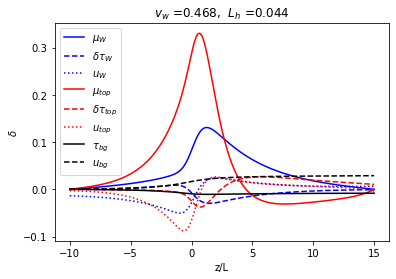

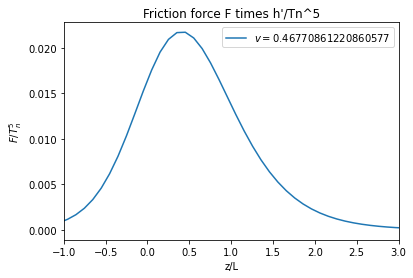

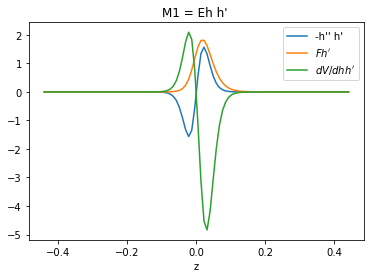

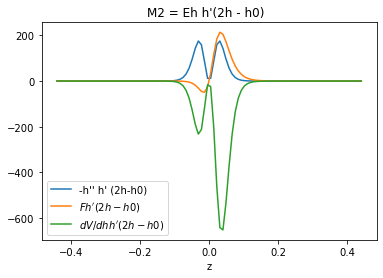

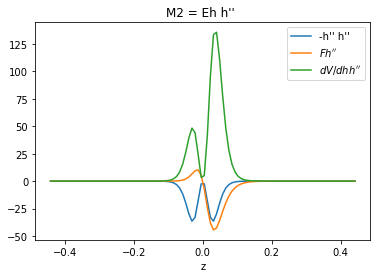

Potential parameters are given by 
 
mus2= 206021.75982232334 muh2= -98986.52078585909 lamh= 0.4593218613575779 lams= 8.353448721134534 lammix= -0.5963415217896889 

Model parameters are 

ms= 880.1970415229969 theta= 0.2317219889711371 muhs= -568.9224229595047 u= 201.621584060062 mu3= 148.61565617705102 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [246.19999499 201.62158302] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
......................................................................................
Tracing phase starting at x = [2.87029667e-08 1.60940082e+02] ; t = 117.49562832833541
Tracing minimum down
traceMinimum t0 = 117.496
...........................
Tracing minimum up
traceMinimum t0 = 117.496
.................................................................................................................................................................................................................................................

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091307,   T_+=84.380299
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6968298795915113, 'Lh': 0.011868473367878893, 'dh': 0, 'h0': 231.00323786475224, 'Ls': 0.011868473367878893, 'ds': 0, 'shigh': 159.99666138043744, 'slow': 198.16604835437954}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6968298795915113, 'Lh': 0.011868473367878893, 'dh': 0, 'h0': 231.00323786475224, 'Ls': 0.011868473367878893, 'ds': 0, 'shigh': 159.99666138043744, 'slow': 198.16604835437954}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:364: RuntimeWarning: invalid value encountered in sqrt


alpha+ = 0.012962
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.477306, T+=102.678067
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=212.090958, slow=193.925665, shigh=160.511143
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.6983644311220318, 'Lh': 0.011868473367878893, 'dh': 0, 'h0': 212.09095811999777, 'Ls': 0.011868473367878893, 'ds': 0, 'shigh': 160.51114267976726, 'slow': 193.92566546141776}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6968298795915113, 'Lh': 0.011868473367878893, 'dh': 0, 'h0': 231.00323786475224, 'Ls': 0.011868473367878893, 'ds': 0, 'shigh': 159.99666138043744, 'slow': 198.16604835437954}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012962
integrating the deflagration component 
........
 Finding velocity and temperature in fron

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.010,  ds=0.318
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.011868473367878893, 'dh': 0, 'h0': 230.88010716697215, 'Ls': 0.010423856035742175, 'ds': 0.3179559163843712, 'shigh': 159.99994195163083, 'slow': 198.14638659564386}
Solving Boltzmann transport equations for vw=0.09130713643992205, Lh=0.011868473367878893, T+=84.38029940203737
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has bee

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.101,  ds=0.331
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.11868473367878894, 'dh': 0, 'h0': 230.84877847237183, 'Ls': 0.10112277448247127, 'ds': 0.33073226226309865, 'shigh': 159.99994195163083, 'slow': 198.14638659564386}
Solving Boltzmann transport equations for vw=0.09130713643992205, Lh=0.11868473367878894, T+=84.38029940203737
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been 

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:383: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.049,  ds=0.214
New guess is given by: 
 ...........
{'vw': 0.2994548103740106, 'Lh': 0.04747389347151557, 'dh': 0, 'h0': 230.12188421818013, 'Ls': 0.04903362655972363, 'ds': 0.2140123068912173, 'shigh': 160.02502306278956, 'slow': 197.99397198332719}
Solving Boltzmann transport equations for vw=0.26956586415852285, Lh=0.04747389347151557, T+=85.31909899600262
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.421126,   T_+=88.624658
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=227.672333, slow=197.414562, shigh=160.114539
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.49890962074802125, 'Lh': 0.011868473367878893, 'dh': 0, 'h0': 227.6723331185713, 'Ls': 0.011868473367878893, 'ds': 0, 'shigh': 160.11453878826597, 'slow': 197.41456201491738}
Solving Boltzmann transport equations for vw=0.42112646055249703, Lh=0.011868473367878893, T+=88.62465800549957
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport eq

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6968298795915113, 'Lh': 0.011868473367878893, 'dh': 0, 'h0': 231.00323786475224, 'Ls': 0.011868473367878893, 'ds': 0, 'shigh': 159.99666138043744, 'slow': 198.16604835437954}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.421126,   T_+=88.624658
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=227.672333, slow=197.414562, shigh=160.114539
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.49890962074802125, 'Lh': 0.11868473367878894, 'dh': 0, 'h0': 227.6723331185713, 'Ls': 0.011868473367878893, 'ds': 0, 'shigh': 160.11453878826597, 'slow': 197.41456201491738}
Solving Boltzmann transport equa

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6968298795915113, 'Lh': 0.011868473367878893, 'dh': 0, 'h0': 231.00323786475224, 'Ls': 0.011868473367878893, 'ds': 0, 'shigh': 159.99666138043744, 'slow': 198.16604835437954}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012962
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.477306, T+=102.678067
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.101,  ds=0.355
New guess is given by: 
 ...........
{'vw': 0.6983644311220318, 'Lh': 0.11868473367878894, 'dh': 0, 'h0': 211.91742957032145, 'Ls': 0.10088316685407055, 'ds': 0.3545260768023855, 'shigh': 160.51114267976726, 'slow': 193.92566546141776}
Solving Boltzmann transport equations for vw=0.4773057138624341, Lh=0.11868473367878894, T+=102.67806675059852
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0

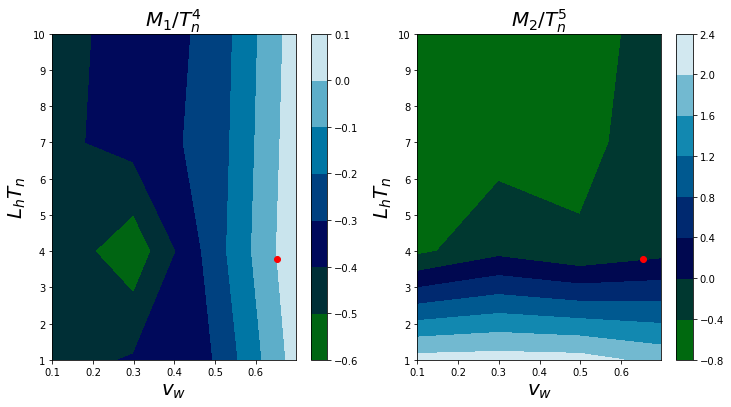

alpha =0.015405271202106276, alpha_N=0.02858636646924472


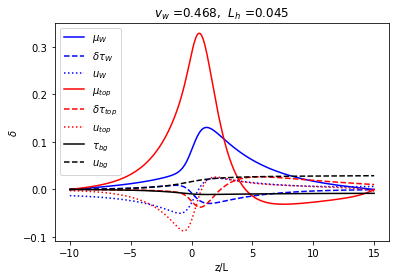

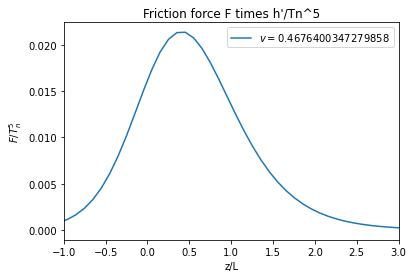

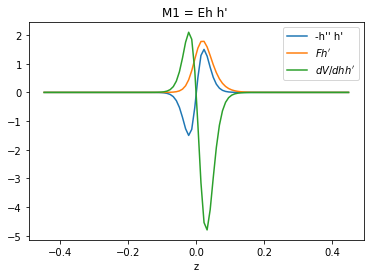

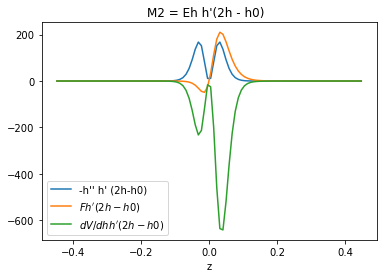

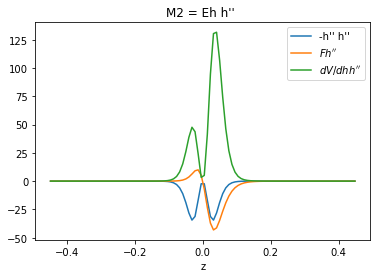

Potential parameters are given by 
 
mus2= 15927.720102917345 muh2= -143750.53378964454 lamh= 0.18548351632766513 lams= 0.5565238459612518 lammix= 2.573792735676606 

Model parameters are 

ms= 421.2351055993957 theta= 0.2070660732877416 muhs= -902.9529229439778 u= 299.4548937696917 mu3= 68.77846761099046 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [246.20000319 299.45489486] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................
Tracing phase starting at x = [4.26551221e-06 2.39659146e+02] ; t = 119.40684627546442
Tracing minimum down
traceMinimum t0 = 119.407
.................
Tracing minimum up
traceMinimum t0 = 119.407
..................................................................................................................................................................
Tunneling from phase 1 to phase 0 at T=0
high_vev = [2.34970856e-06 2.39092609e+02

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091405,   T_+=87.134900
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6949143877427365, 'Lh': 0.011493089595806635, 'dh': 0, 'h0': 228.73325083357327, 'Ls': 0.011493089595806635, 'ds': 0, 'shigh': 239.6902753109244, 'slow': 295.8823207234997}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6949143877427365, 'Lh': 0.011493089595806635, 'dh': 0, 'h0': 228.73325083357327, 'Ls': 0.011493089595806635, 'ds': 0, 'shigh': 239.6902753109244, 'slow': 295.8823207234997}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:364: RuntimeWarning: invalid value encountered in sqrt


alpha+ = 0.012864
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.477711, T+=105.930759
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=206.838704, slow=291.001741, shigh=239.719323
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.6977722987231375, 'Lh': 0.011493089595806635, 'dh': 0, 'h0': 206.8387042391262, 'Ls': 0.011493089595806635, 'ds': 0, 'shigh': 239.7193229352598, 'slow': 291.001740640423}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6949143877427365, 'Lh': 0.011493089595806635, 'dh': 0, 'h0': 228.73325083357327, 'Ls': 0.011493089595806635, 'ds': 0, 'shigh': 239.6902753109244, 'slow': 295.8823207234997}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012864
integrating the deflagration component 
........
 Finding velocity and temperature in front of t

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.011,  ds=0.059
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.011493089595806635, 'dh': 0, 'h0': 228.5219895546689, 'Ls': 0.011126211348330653, 'ds': 0.05887400727400539, 'shigh': 239.69088677970345, 'slow': 295.8612528843167}
Solving Boltzmann transport equations for vw=0.09140520861845003, Lh=0.011493089595806635, T+=87.1348999451417
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been 

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:383: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.046,  ds=0.049
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.04597235838322654, 'dh': 0, 'h0': 228.4766810091162, 'Ls': 0.04597234908779419, 'ds': 0.048637741097365454, 'shigh': 239.69088677970345, 'slow': 295.8612528843167}
Solving Boltzmann transport equations for vw=0.09140520861845003, Lh=0.04597235838322654, T+=87.1348999451417
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been ad

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.011,  ds=0.063
New guess is given by: 
 ...........
{'vw': 0.2992574329077125, 'Lh': 0.011493089595806635, 'dh': 0, 'h0': 227.29121279229292, 'Ls': 0.011186067244051029, 'ds': 0.06309913203775956, 'shigh': 239.69521277844862, 'slow': 295.69762782034184}
Solving Boltzmann transport equations for vw=0.26971279492110456, Lh=0.011493089595806635, T+=88.09216436049547
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=227.5901470173747.

guess dict has been updated   
......................
h0=227.590
New guess is given by: 
 ...........
{'vw': 0.2992574329077125, 'Lh': 0.11493089595806635, 'dh': 0, 'h0': 227.5901470173747, 'Ls': 0.011493089595806635, 'ds': 0, 'shigh': 239.69521277844862, 'slow': 295.69762782034184}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.115,  ds=0.051
New guess is given by: 
 ...........
{'vw': 0.2992574329077125, 'Lh': 0.11493089595806635, 'dh': 0, 'h0': 227.5901470173747, 'Ls': 0.11493088657032989, 'ds': 0.05091990055037794, 'shigh': 239.69521277844862, 'slow': 295.69762782034184}
Solving Boltzmann transport equations for vw=0.26971279492

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.421528,   T_+=91.472306
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=224.933698, slow=295.067544, shigh=239.708231
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.49851486581542503, 'Lh': 0.011493089595806635, 'dh': 0, 'h0': 224.9336979481355, 'Ls': 0.011493089595806635, 'ds': 0, 'shigh': 239.70823077731467, 'slow': 295.06754441483525}
Solving Boltzmann transport equations for vw=0.4215283765518766, Lh=0.011493089595806635, T+=91.47230595915924
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equ

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6949143877427365, 'Lh': 0.011493089595806635, 'dh': 0, 'h0': 228.73325083357327, 'Ls': 0.011493089595806635, 'ds': 0, 'shigh': 239.6902753109244, 'slow': 295.8823207234997}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.421528,   T_+=91.472306
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=224.933698, slow=295.067544, shigh=239.708231
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.49851486581542503, 'Lh': 0.11493089595806635, 'dh': 0, 'h0': 224.9336979481355, 'Ls': 0.011493089595806635, 'ds': 0, 'shigh': 239.70823077731467, 'slow': 295.06754441483525}
Solving Boltzmann transport equati

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6949143877427365, 'Lh': 0.011493089595806635, 'dh': 0, 'h0': 228.73325083357327, 'Ls': 0.011493089595806635, 'ds': 0, 'shigh': 239.6902753109244, 'slow': 295.8823207234997}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012864
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.477711, T+=105.930759
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.044,  ds=0.080
New guess is given by: 
 ...........
{'vw': 0.647901458419795, 'Lh': 0.04404740658618483, 'dh': 0, 'h0': 213.5146716791619, 'Ls': 0.0440473955157357, 'ds': 0.07953863296025275, 'shigh': 239.72398609903274, 'slow': 292.7056452159735}
Hydrodynamics taken into acount
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.015539
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.467132, T+=101.043383
Solving Boltzmann transport equations for vw=0.46713184496781585, Lh=0.04404740658618483, T+=101.04338338125417
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
...

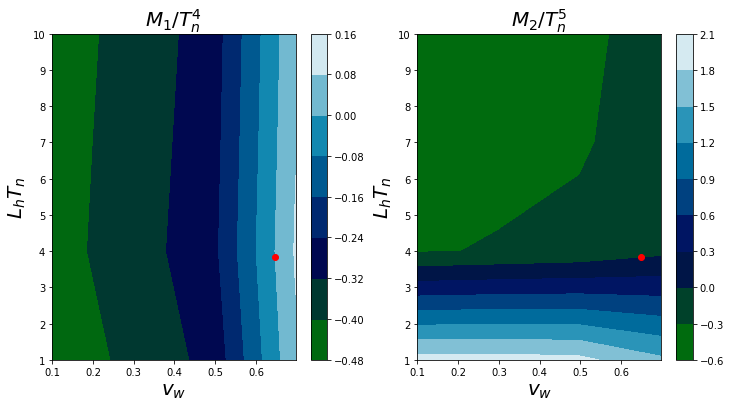

alpha =0.015538871833819499, alpha_N=0.028261692934769933


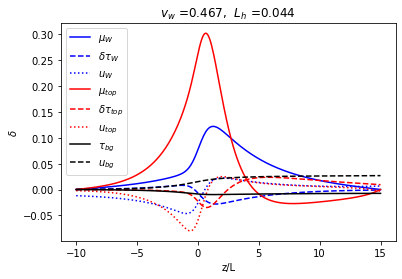

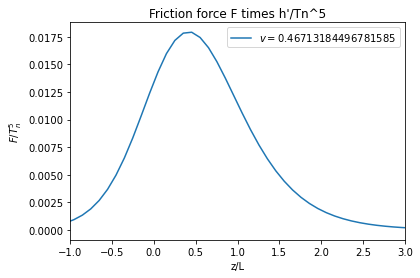

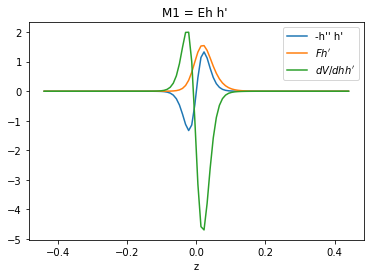

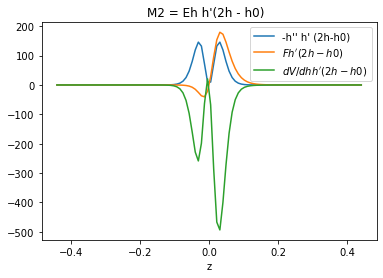

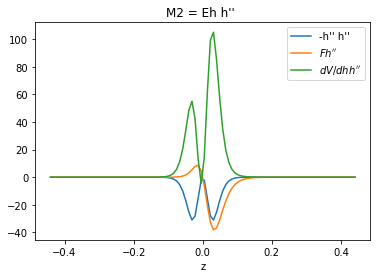

Potential parameters are given by 
 
mus2= 168021.68860773204 muh2= -86184.06058239372 lamh= 0.3968383374970591 lams= 7.88828701602721 lammix= 0.002503590071914259 

Model parameters are 

ms= 819.2455042799322 theta= 0.22440836603858624 muhs= -578.113867194468 u= 190.7647519808669 mu3= 142.96199737497759 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [246.19999925 190.76475149] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.....................................................................................
Tracing phase starting at x = [1.57191221e-06 1.49605615e+02] ; t = 118.08211388888895
Tracing minimum down
traceMinimum t0 = 118.082
.............................
Tracing minimum up
traceMinimum t0 = 118.082
...............................................................................................................................................................................................................................................

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091530,   T_+=85.185922
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6935501025441027, 'Lh': 0.011755800625571286, 'dh': 0, 'h0': 230.39572388459825, 'Ls': 0.011755800625571286, 'ds': 0, 'shigh': 148.5828484392713, 'slow': 187.28515629921802}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6935501025441027, 'Lh': 0.011755800625571286, 'dh': 0, 'h0': 230.39572388459825, 'Ls': 0.011755800625571286, 'ds': 0, 'shigh': 148.5828484392713, 'slow': 187.28515629921802}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


alpha+ = 0.012738
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.478232, T+=103.436828
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=211.033889, slow=183.057962, shigh=149.154541
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.6970113094380601, 'Lh': 0.011755800625571286, 'dh': 0, 'h0': 211.03388917240034, 'Ls': 0.011755800625571286, 'ds': 0, 'shigh': 149.15454097646943, 'slow': 183.0579617890253}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6935501025441027, 'Lh': 0.011755800625571286, 'dh': 0, 'h0': 230.39572388459825, 'Ls': 0.011755800625571286, 'ds': 0, 'shigh': 148.5828484392713, 'slow': 187.28515629921802}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012738
integrating the deflagration component 
........
 Finding velocity and temperature in front 

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.010,  ds=0.286
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.011755800625571286, 'dh': 0, 'h0': 230.2629148359273, 'Ls': 0.010418110659472965, 'ds': 0.28567410097893337, 'shigh': 148.58651668886785, 'slow': 187.2658386077826}
Solving Boltzmann transport equations for vw=0.0915301863693152, Lh=0.011755800625571286, T+=85.18592151973188
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been 

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:383: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.047,  ds=0.234
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.04702320250228515, 'dh': 0, 'h0': 230.24031592829004, 'Ls': 0.04702319776909239, 'ds': 0.23405586041353196, 'shigh': 148.58651668886785, 'slow': 187.2658386077826}
Solving Boltzmann transport equations for vw=0.0915301863693152, Lh=0.04702320250228515, T+=85.18592151973188
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been ad

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.269899,   T_+=86.107302
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=229.626470, slow=187.116534, shigh=148.614532
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.2990037698126867, 'Lh': 0.011755800625571286, 'dh': 0, 'h0': 229.62646962984925, 'Ls': 0.011755800625571286, 'ds': 0, 'shigh': 148.61453248020968, 'slow': 187.11653418040908}
Solving Boltzmann transport equations for vw=0.26989893395766595, Lh=0.011755800625571286, T+=86.10730150164575
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport eq

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6935501025441027, 'Lh': 0.011755800625571286, 'dh': 0, 'h0': 230.39572388459825, 'Ls': 0.011755800625571286, 'ds': 0, 'shigh': 148.5828484392713, 'slow': 187.28515629921802}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.269899,   T_+=86.107302
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=229.626470, slow=187.116534, shigh=148.614532
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.2990037698126867, 'Lh': 0.11755800625571287, 'dh': 0, 'h0': 229.62646962984925, 'Ls': 0.011755800625571286, 'ds': 0, 'shigh': 148.61453248020968, 'slow': 187.11653418040908}
Solving Boltzmann transport equat

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6935501025441027, 'Lh': 0.011755800625571286, 'dh': 0, 'h0': 230.39572388459825, 'Ls': 0.011755800625571286, 'ds': 0, 'shigh': 148.5828484392713, 'slow': 187.28515629921802}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.422037,   T_+=89.368243
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=227.024646, slow=186.546602, shigh=148

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.010,  ds=0.313
New guess is given by: 
 ...........
{'vw': 0.6970113094380601, 'Lh': 0.011755800625571286, 'dh': 0, 'h0': 210.58415489167908, 'Ls': 0.010460157156532214, 'ds': 0.3126549783581013, 'shigh': 149.15454097646943, 'slow': 183.0579617890253}
Solving Boltzmann transport equations for vw=0.4782323167775996, Lh=0.011755800625571286, T+=103.43682769888997
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=210.82878316630266.

guess dict has been updated   
......................
h0=210.829
New guess is given by: 
 ...........
{'vw': 0.6970113094380601, 'Lh': 0.11755800625571287, 'dh': 0, 'h0': 210.82878316630266, 'Ls': 0.011755800625571286, 'ds': 0, 'shigh': 149.15454097646943, 'slow': 183.0579617890253}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.118,  ds=0.259
New guess is given by: 
 ...........
{'vw': 0.6970113094380601, 'Lh': 0.11755800625571287, 'dh': 0, 'h0': 210.82878316630266, 'Ls': 0.11755799981057248, 'ds': 0.25886029066036853, 'shigh': 149.15454097646943, 'slow': 183.0579617890253}
Solving Boltzmann transport equations for vw=0.4782323167

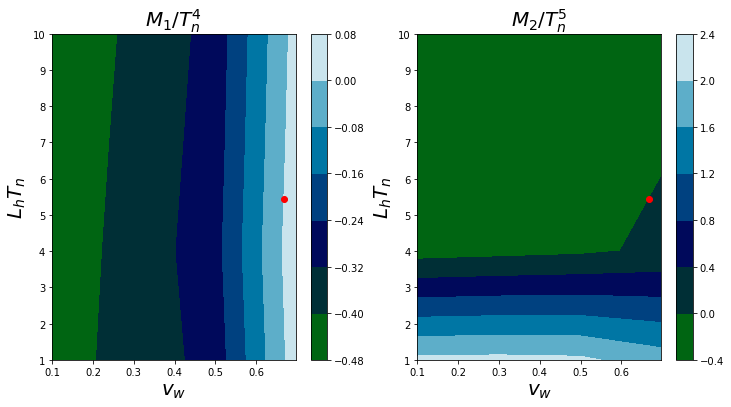

alpha =0.014263204001924842, alpha_N=0.027848024549123697


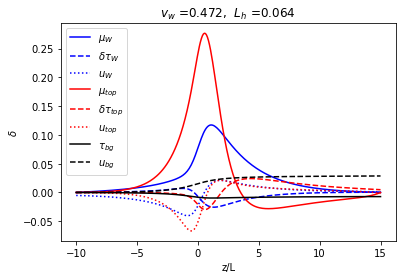

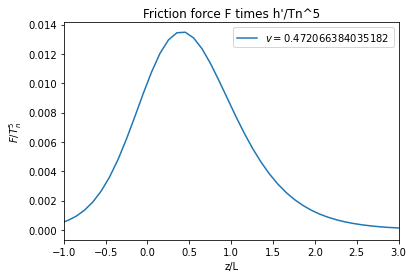

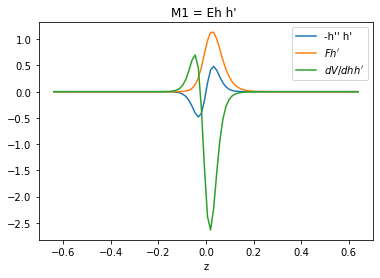

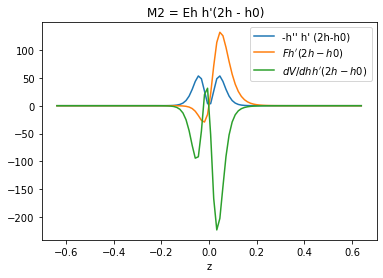

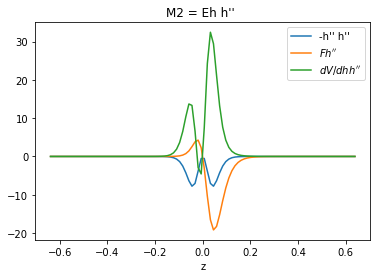

Potential parameters are given by 
 
mus2= 81913.64513528242 muh2= -106379.1415518833 lamh= 0.3319856061851484 lams= 6.212084769839573 lammix= 1.1996005593046926 

Model parameters are 

ms= 748.0991678984124 theta= -0.21428098630023115 muhs= 717.1410826200882 u= -215.09298998648185 mu3= -654.5900989669827 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [ 246.20000577 -215.09299202] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...................................................................................
Tracing phase starting at x = [-1.61928959e-06 -1.74130004e+02] ; t = 117.40120082624807
Tracing minimum down
traceMinimum t0 = 117.401
.........................
Tracing minimum up
traceMinimum t0 = 117.401
................................................................................................................................................................................................................................
Tunneling from 

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091611,   T_+=85.323779
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6902169125919432, 'Lh': 0.011736650353412087, 'dh': 0, 'h0': 230.1166158389963, 'Ls': 0.011736650353412087, 'ds': 0, 'shigh': -173.3707912170633, 'slow': -211.70328787332585}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6902169125919432, 'Lh': 0.011736650353412087, 'dh': 0, 'h0': 230.1166158389963, 'Ls': 0.011736650353412087, 'ds': 0, 'shigh': -173.3707912170633, 'slow': -211.70328787332585}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


alpha+ = 0.012655
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.478574, T+=103.522663
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6902169125919432, 'Lh': 0.011736650353412087, 'dh': 0, 'h0': 230.1166158389963, 'Ls': 0.011736650353412087, 'ds': 0, 'shigh': -173.3707912170633, 'slow': -211.70328787332585}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.014220
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.472239, T+=100.549632
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6902169125919432, 'Lh': 0.011736650353412087, 'dh': 0, 'h0': 230.1166158389963, 'Ls': 0.011736650353412087, 'ds': 0, 'shigh': -173.3707912170633, 'slow': -211.70328787332585}
This 

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.374689,   T_+=87.737899
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6902169125919432, 'Lh': 0.011736650353412087, 'dh': 0, 'h0': 230.1166158389963, 'Ls': 0.011736650353412087, 'ds': 0, 'shigh': -173.3707912170633, 'slow': -211.70328787332585}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.351590,   T_+=87.260196
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6902169125919432, 'Lh': 0.011736650353412087, 'dh': 0, 'h0': 230.1166158389963, 'Ls': 0.011736650353412087, 'ds': 0, 'shigh': -173.3707912170633, 'slow': -211.70328787332585}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and tem

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:364: RuntimeWarning: invalid value encountered in sqrt


isEWSB=True 

Tracing phase starting at x = [246.20000237 322.38587177] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
..............................................................................................
Tracing phase starting at x = [-2.09682764e-06  2.57514334e+02] ; t = 121.07765423943616
Tracing minimum down
traceMinimum t0 = 121.078
.................
Tracing minimum up
traceMinimum t0 = 121.078
.........................................................................................................................................................
Tunneling from phase 1 to phase 0 at T=0
high_vev = [3.41558132e-06 2.56798051e+02]
low_vev = [246.20000103 322.38587086]
Path deformation converged. 15 steps. fRatio = 9.15572e-03
Path deformation converged. 1 steps. fRatio = 7.65297e-03
Tunneling from phase 1 to phase 0 at T=53.79209
high_vev = [5.44064384e-07 2.57143750e+02]
low_vev = [243.64708989 321.91641648]
Path deformation converged. 14 steps. fRatio = 1.34013e-02
Path

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091637,   T_+=88.500504
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6926773846247918, 'Lh': 0.011315310635147654, 'dh': 0, 'h0': 227.67847788386868, 'Ls': 0.011315310635147654, 'ds': 0, 'shigh': 257.48236306925537, 'slow': 318.8276391854133}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6926773846247918, 'Lh': 0.011315310635147654, 'dh': 0, 'h0': 227.67847788386868, 'Ls': 0.011315310635147654, 'ds': 0, 'shigh': 257.48236306925537, 'slow': 318.8276391854133}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


alpha+ = 0.012629
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.478683, T+=107.350062
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=205.066313, slow=313.972378, shigh=257.541345
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.6963544267262123, 'Lh': 0.011315310635147654, 'dh': 0, 'h0': 205.0663132672491, 'Ls': 0.011315310635147654, 'ds': 0, 'shigh': 257.54134521609956, 'slow': 313.9723775158016}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6926773846247918, 'Lh': 0.011315310635147654, 'dh': 0, 'h0': 227.67847788386868, 'Ls': 0.011315310635147654, 'ds': 0, 'shigh': 257.48236306925537, 'slow': 318.8276391854133}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012629
integrating the deflagration component 
........
 Finding velocity and temperature in front o

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.011,  ds=-0.016
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.011315310635147654, 'dh': 0, 'h0': 227.44148127070827, 'Ls': 0.011377098627460716, 'ds': -0.01597305711025202, 'shigh': 257.4831181487789, 'slow': 318.8070509843405}
Solving Boltzmann transport equations for vw=0.09163709470531978, Lh=0.011315310635147654, T+=88.50050389374218
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has be

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:383: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.045,  ds=-0.015
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.045261242540590614, 'dh': 0, 'h0': 227.39686793721836, 'Ls': 0.0452612316302425, 'ds': -0.01483826917508216, 'shigh': 257.4831181487789, 'slow': 318.8070509843405}
Solving Boltzmann transport equations for vw=0.09163709470531978, Lh=0.045261242540590614, T+=88.50050389374218
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:464: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6926773846247918, 'Lh': 0.011315310635147654, 'dh': 0, 'h0': 227.67847788386868, 'Ls': 0.011315310635147654, 'ds': 0, 'shigh': 257.48236306925537, 'slow': 318.8276391854133}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.091637,   T_+=88.500504
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=227.576583, slow=318.807051, shigh=257.483118
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.07920717444603358, 'dh': 0, 'h0': 227.57658344105045, 'Ls': 0.011315310635147654, 'ds': 0, 'shigh': 257.4831181487789, 'slow': 318.8070509843405}
Solving Boltzmann transport equations for vw=0.09163709470531978, Lh=0.07920717444603358, T+=88.50050389374218
.......
Initializing interpolation for damping term $A^{-1}

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.270058,   T_+=89.445958
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=226.789186, slow=318.647493, shigh=257.488539
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29878480890873743, 'Lh': 0.011315310635147654, 'dh': 0, 'h0': 226.7891856365573, 'Ls': 0.011315310635147654, 'ds': 0, 'shigh': 257.48853876031757, 'slow': 318.6474929629304}
Solving Boltzmann transport equations for vw=0.27005762460323585, Lh=0.011315310635147654, T+=89.44595833079903
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equ

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6926773846247918, 'Lh': 0.011315310635147654, 'dh': 0, 'h0': 227.67847788386868, 'Ls': 0.011315310635147654, 'ds': 0, 'shigh': 257.48236306925537, 'slow': 318.8276391854133}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.270058,   T_+=89.445958
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=226.789186, slow=318.647493, shigh=257.488539
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29878480890873743, 'Lh': 0.11315310635147655, 'dh': 0, 'h0': 226.7891856365573, 'Ls': 0.011315310635147654, 'ds': 0, 'shigh': 257.48853876031757, 'slow': 318.6474929629304}
Solving Boltzmann transport equati

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6926773846247918, 'Lh': 0.011315310635147654, 'dh': 0, 'h0': 227.67847788386868, 'Ls': 0.011315310635147654, 'ds': 0, 'shigh': 257.48236306925537, 'slow': 318.8276391854133}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.422465,   T_+=92.791112
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=223.782877, slow=318.032082, shigh=257

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.012,  ds=0.037
New guess is given by: 
 ...........
{'vw': 0.6963544267262123, 'Lh': 0.011315310635147654, 'dh': 0, 'h0': 203.86216385120116, 'Ls': 0.011644404317106784, 'ds': 0.03720836285411509, 'shigh': 257.54134521609956, 'slow': 313.9723775158016}
Solving Boltzmann transport equations for vw=0.47868344127551515, Lh=0.011315310635147654, T+=107.35006154556925
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=204.51593287021146.

guess dict has been updated   
......................
h0=204.516
New guess is given by: 
 ...........
{'vw': 0.6963544267262123, 'Lh': 0.11315310635147655, 'dh': 0, 'h0': 204.51593287021146, 'Ls': 0.011315310635147654, 'ds': 0, 'shigh': 257.54134521609956, 'slow': 313.9723775158016}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.113,  ds=0.034
New guess is given by: 
 ...........
{'vw': 0.6963544267262123, 'Lh': 0.11315310635147655, 'dh': 0, 'h0': 204.51593287021146, 'Ls': 0.11315309363428223, 'ds': 0.03367464596273161, 'shigh': 257.54134521609956, 'slow': 313.9723775158016}
Solving Boltzmann transport equations for vw=0.4786834412

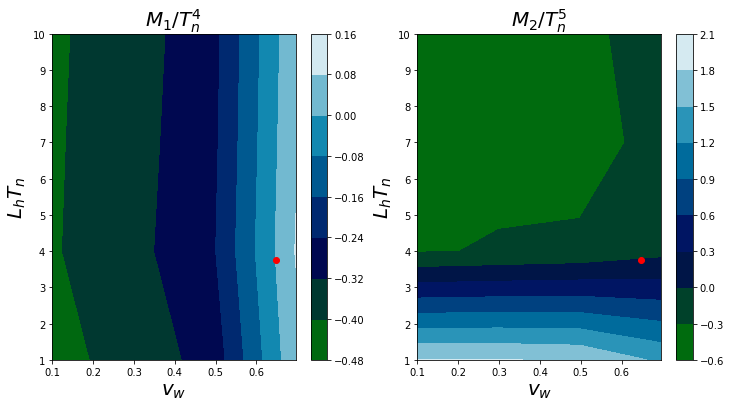

alpha =0.015229425371751829, alpha_N=0.02749417659740872


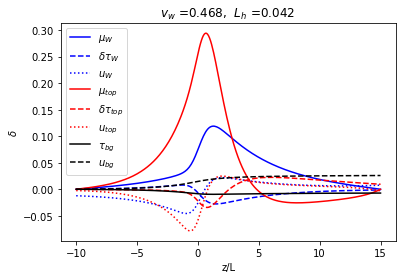

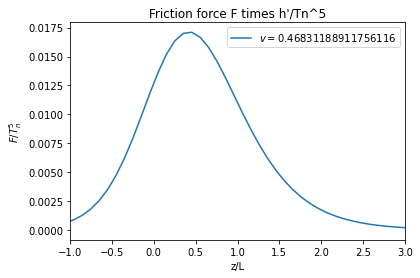

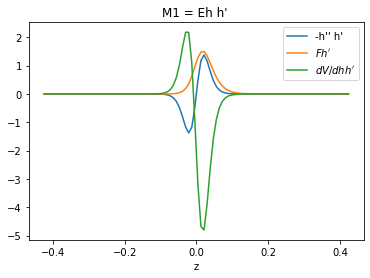

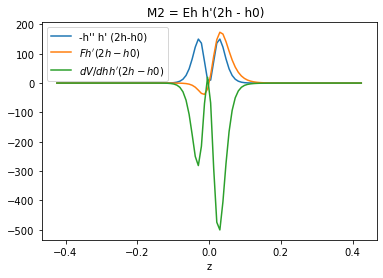

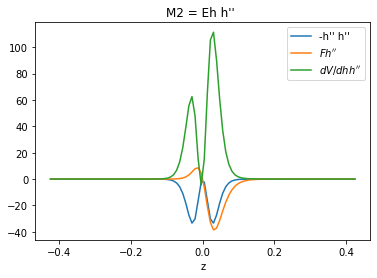

Potential parameters are given by 
 
mus2= 12109.68632348461 muh2= -140874.1132774899 lamh= 0.17931649074561734 lams= 0.49757846828272834 lammix= 2.5248441141257136 

Model parameters are 

ms= 405.26195508716756 theta= 0.20387146581813256 muhs= -883.5016910103578 u= 302.52948037534645 mu3= 70.87927590163999 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [246.20000441 302.52948265] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
..............................................................................................
Tracing phase starting at x = [-3.9072377e-06  2.4046886e+02] ; t = 120.1422499497432
Tracing minimum down
traceMinimum t0 = 120.142
.................
Tracing minimum up
traceMinimum t0 = 120.142
................................................................................................................................................................
Tunneling from phase 1 to phase 0 at T=0
high_vev = [9.59913289e-06 2.39896758e

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091667,   T_+=88.119773
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6900672230256772, 'Lh': 0.011364144526847206, 'dh': 0, 'h0': 227.97532190434782, 'Ls': 0.011364144526847206, 'ds': 0, 'shigh': 240.51614146929833, 'slow': 298.8599673026819}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6900672230256772, 'Lh': 0.011364144526847206, 'dh': 0, 'h0': 227.97532190434782, 'Ls': 0.011364144526847206, 'ds': 0, 'shigh': 240.51614146929833, 'slow': 298.8599673026819}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


alpha+ = 0.012599
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.478808, T+=106.857521
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=205.554027, slow=293.887907, shigh=240.534537
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.696172585547612, 'Lh': 0.011364144526847206, 'dh': 0, 'h0': 205.55402661634184, 'Ls': 0.011364144526847206, 'ds': 0, 'shigh': 240.53453726945574, 'slow': 293.8879073218683}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6900672230256772, 'Lh': 0.011364144526847206, 'dh': 0, 'h0': 227.97532190434782, 'Ls': 0.011364144526847206, 'ds': 0, 'shigh': 240.51614146929833, 'slow': 298.8599673026819}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012599
integrating the deflagration component 
........
 Finding velocity and temperature in front o

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.011,  ds=0.030
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.011364144526847206, 'dh': 0, 'h0': 227.75000597717528, 'Ls': 0.011198899277391776, 'ds': 0.029738848570826797, 'shigh': 240.51664609224534, 'slow': 298.83885368872427}
Solving Boltzmann transport equations for vw=0.09166653710768946, Lh=0.011364144526847206, T+=88.11977261337724
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has b

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:383: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.045,  ds=0.025
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.04545657810738882, 'dh': 0, 'h0': 227.70666008705587, 'Ls': 0.04545656854556509, 'ds': 0.025034508126388504, 'shigh': 240.51664609224534, 'slow': 298.83885368872427}
Solving Boltzmann transport equations for vw=0.09166653710768946, Lh=0.04545657810738882, T+=88.11977261337724
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.270101,   T_+=89.057629
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=227.100362, slow=298.675477, shigh=240.520428
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29872419518253734, 'Lh': 0.011364144526847206, 'dh': 0, 'h0': 227.10036225469486, 'Ls': 0.011364144526847206, 'ds': 0, 'shigh': 240.52042789717166, 'slow': 298.67547674173466}
Solving Boltzmann transport equations for vw=0.270100635946836, Lh=0.011364144526847206, T+=89.05762855985681
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equ

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:464: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6900672230256772, 'Lh': 0.011364144526847206, 'dh': 0, 'h0': 227.97532190434782, 'Ls': 0.011364144526847206, 'ds': 0, 'shigh': 240.51614146929833, 'slow': 298.8599673026819}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.270101,   T_+=89.057629
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=227.100362, slow=298.675477, shigh=240.520428
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29872419518253734, 'Lh': 0.07954901168793044, 'dh': 0, 'h0': 227.10036225469486, 'Ls': 0.011364144526847206, 'ds': 0, 'shigh': 240.52042789717166, 'slow': 298.67547674173466}
Solving Boltzmann transport equations for vw=0.270100635946836, Lh=0.07954901168793044, T+=89.05762855985681
.......
Initializing interpolation for damp

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6900672230256772, 'Lh': 0.011364144526847206, 'dh': 0, 'h0': 227.97532190434782, 'Ls': 0.011364144526847206, 'ds': 0, 'shigh': 240.51614146929833, 'slow': 298.8599673026819}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.422585,   T_+=92.377779
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=224.138950, slow=298.045324, shigh=240

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6900672230256772, 'Lh': 0.011364144526847206, 'dh': 0, 'h0': 227.97532190434782, 'Ls': 0.011364144526847206, 'ds': 0, 'shigh': 240.51614146929833, 'slow': 298.8599673026819}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012599
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.478808, T+=106.857521
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.080,  ds=0.070
New guess is given by: 
 ...........
{'vw': 0.696172585547612, 'Lh': 0.07954901168793044, 'dh': 0, 'h0': 204.9805762978316, 'Ls': 0.07954899919943485, 'ds': 0.06997246382387738, 'shigh': 240.53453726945574, 'slow': 293.8879073218683}
Solving Boltzmann transport equations for vw=0.4788084740087012, Lh=0.07954901168793044, T+=106.85752075509657
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-

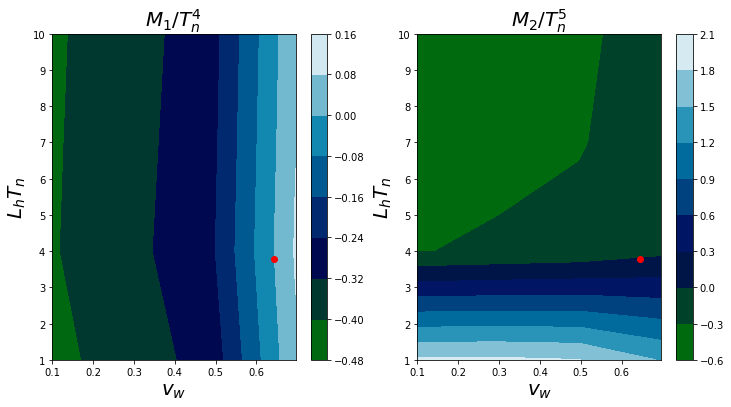

alpha =0.015332709506355997, alpha_N=0.02739674902742201


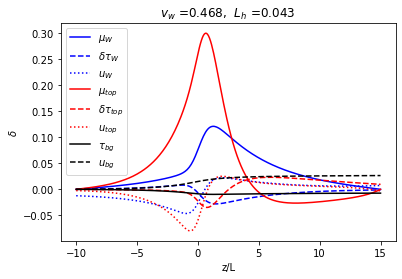

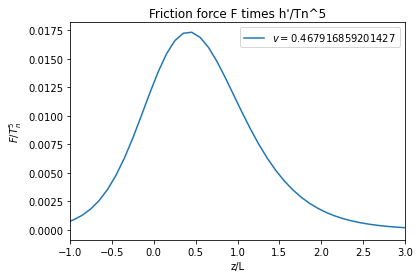

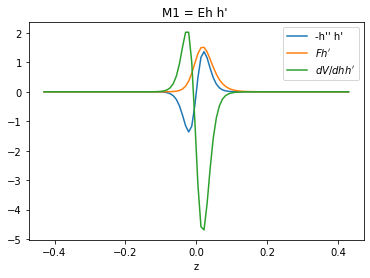

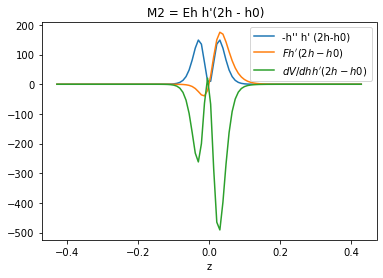

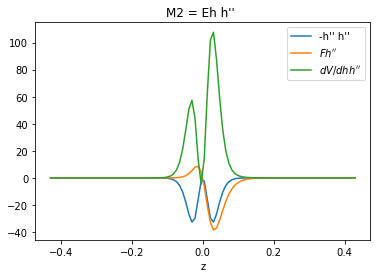

Potential parameters are given by 
 
mus2= 167775.8402169007 muh2= -88655.67984197823 lamh= 0.4107250853289292 lams= 7.58876223756343 lammix= -0.10102369983147352 

Model parameters are 

ms= 819.5208898087633 theta= 0.230175647271456 muhs= -572.1286463594603 u= 195.1110983204381 mu3= 149.57354223802488 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [246.19999675 195.11109792] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.....................................................................................
Tracing phase starting at x = [-5.37810237e-06  1.53390952e+02] ; t = 117.84678606793332
Tracing minimum down
traceMinimum t0 = 117.847
...........................
Tracing minimum up
traceMinimum t0 = 117.847
.................................................................................................................................................................................................................................................

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091694,   T_+=85.512735
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6892362018416309, 'Lh': 0.011710552915596868, 'dh': 0, 'h0': 230.16980710025334, 'Ls': 0.011710552915596868, 'ds': 0, 'shigh': 152.46290275531226, 'slow': 191.49015197755986}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6892362018416309, 'Lh': 0.011710552915596868, 'dh': 0, 'h0': 230.16980710025334, 'Ls': 0.011710552915596868, 'ds': 0, 'shigh': 152.46290275531226, 'slow': 191.49015197755986}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:364: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


alpha+ = 0.012571
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.478923, T+=103.668731
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=210.620640, slow=187.116667, shigh=152.987477
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.696005454510004, 'Lh': 0.011710552915596868, 'dh': 0, 'h0': 210.62063954196927, 'Ls': 0.011710552915596868, 'ds': 0, 'shigh': 152.98747671138278, 'slow': 187.11666694653542}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6892362018416309, 'Lh': 0.011710552915596868, 'dh': 0, 'h0': 230.16980710025334, 'Ls': 0.011710552915596868, 'ds': 0, 'shigh': 152.46290275531226, 'slow': 191.49015197755986}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012571
integrating the deflagration component 
........
 Finding velocity and temperature in front

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.010,  ds=0.296
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.011710552915596868, 'dh': 0, 'h0': 230.03753676918785, 'Ls': 0.010364018020095926, 'ds': 0.2960474087420608, 'shigh': 152.46625785926378, 'slow': 191.47038931927722}
Solving Boltzmann transport equations for vw=0.09169353930749558, Lh=0.011710552915596868, T+=85.51273456041183
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has bee

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:383: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.047,  ds=0.243
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.04684221166238747, 'dh': 0, 'h0': 230.01620789188624, 'Ls': 0.04684220704627075, 'ds': 0.24332338435860001, 'shigh': 152.46625785926378, 'slow': 191.47038931927722}
Solving Boltzmann transport equations for vw=0.09169353930749558, Lh=0.04684221166238747, T+=85.51273456041183
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been 

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.270140,   T_+=86.419626
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=229.403258, slow=191.317834, shigh=152.491656
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29866848483666797, 'Lh': 0.011710552915596868, 'dh': 0, 'h0': 229.40325802836065, 'Ls': 0.011710552915596868, 'ds': 0, 'shigh': 152.49165559632698, 'slow': 191.31783365077786}
Solving Boltzmann transport equations for vw=0.2701398670967115, Lh=0.011710552915596868, T+=86.41962570521822
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport eq

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6892362018416309, 'Lh': 0.011710552915596868, 'dh': 0, 'h0': 230.16980710025334, 'Ls': 0.011710552915596868, 'ds': 0, 'shigh': 152.46290275531226, 'slow': 191.49015197755986}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.270140,   T_+=86.419626
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=229.403258, slow=191.317834, shigh=152.491656
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29866848483666797, 'Lh': 0.11710552915596867, 'dh': 0, 'h0': 229.40325802836065, 'Ls': 0.011710552915596868, 'ds': 0, 'shigh': 152.49165559632698, 'slow': 191.31783365077786}
Solving Boltzmann transport equ

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6892362018416309, 'Lh': 0.011710552915596868, 'dh': 0, 'h0': 230.16980710025334, 'Ls': 0.011710552915596868, 'ds': 0, 'shigh': 152.46290275531226, 'slow': 191.49015197755986}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.422695,   T_+=89.632158
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=226.809919, slow=190.735386, shigh=15

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.010,  ds=0.322
New guess is given by: 
 ...........
{'vw': 0.696005454510004, 'Lh': 0.011710552915596868, 'dh': 0, 'h0': 210.18497857202195, 'Ls': 0.010407239027173845, 'ds': 0.3219921353603163, 'shigh': 152.98747671138278, 'slow': 187.11666694653542}
Solving Boltzmann transport equations for vw=0.4789234497700934, Lh=0.011710552915596868, T+=103.66873079316076
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=210.42156036637707.

guess dict has been updated   
......................
h0=210.422
New guess is given by: 
 ...........
{'vw': 0.696005454510004, 'Lh': 0.11710552915596867, 'dh': 0, 'h0': 210.42156036637707, 'Ls': 0.011710552915596868, 'ds': 0, 'shigh': 152.98747671138278, 'slow': 187.11666694653542}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.117,  ds=0.267
New guess is given by: 
 ...........
{'vw': 0.696005454510004, 'Lh': 0.11710552915596867, 'dh': 0, 'h0': 210.42156036637707, 'Ls': 0.11710552284252729, 'ds': 0.2673141084154776, 'shigh': 152.98747671138278, 'slow': 187.11666694653542}
Solving Boltzmann transport equations for vw=0.47892344977

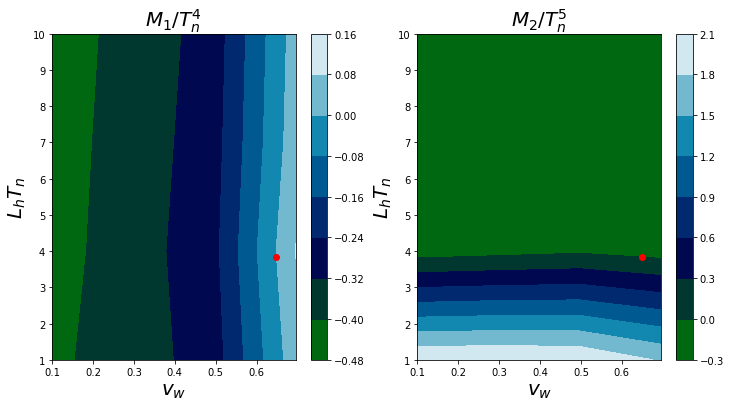

alpha =0.015041732366189433, alpha_N=0.027307403527932785


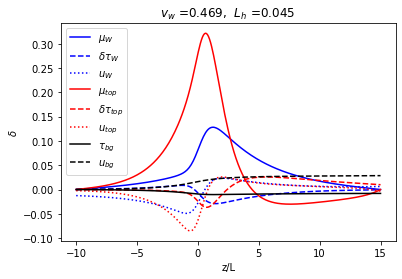

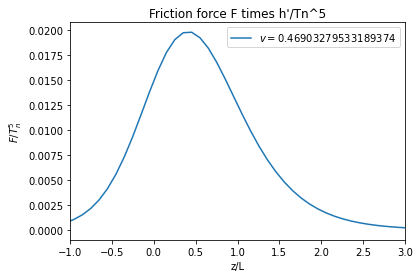

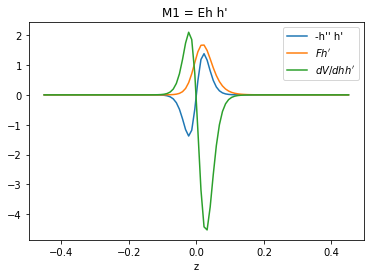

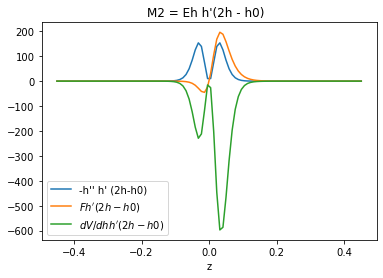

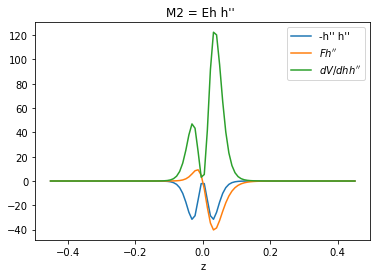

Potential parameters are given by 
 
mus2= 14758.494968709587 muh2= -142135.01396731165 lamh= 0.18701416581060043 lams= 0.5425445578642355 lammix= 2.4572019837264922 

Model parameters are 

ms= 415.496523070776 theta= 0.2131325403788502 muhs= -878.4050535031444 u= 303.83304989264184 mu3= 72.98965688473851 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [246.20000217 303.83305149] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.................................................................................................
Tracing phase starting at x = [-4.07717101e-06  2.43227741e+02] ; t = 119.53958202677497
Tracing minimum down
traceMinimum t0 = 119.54
.................
Tracing minimum up
traceMinimum t0 = 119.54
....................................................................................................................................................................
Tunneling from phase 1 to phase 0 at T=0
high_vev = [-3.81052322e-06  2.4

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091873,   T_+=88.303141
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6839008076531506, 'Lh': 0.011340166858189666, 'dh': 0, 'h0': 227.8224642881271, 'Ls': 0.011340166858189666, 'ds': 0, 'shigh': 243.2857076742944, 'slow': 299.96853237534214}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6839008076531506, 'Lh': 0.011340166858189666, 'dh': 0, 'h0': 227.8224642881271, 'Ls': 0.011340166858189666, 'ds': 0, 'shigh': 243.2857076742944, 'slow': 299.96853237534214}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


alpha+ = 0.012387
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.479695, T+=106.862378
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=205.293495, slow=294.800264, shigh=243.295963
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.694886411220506, 'Lh': 0.011340166858189666, 'dh': 0, 'h0': 205.29349526829787, 'Ls': 0.011340166858189666, 'ds': 0, 'shigh': 243.2959627519227, 'slow': 294.8002637804292}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6839008076531506, 'Lh': 0.011340166858189666, 'dh': 0, 'h0': 227.8224642881271, 'Ls': 0.011340166858189666, 'ds': 0, 'shigh': 243.2857076742944, 'slow': 299.96853237534214}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012387
integrating the deflagration component 
........
 Finding velocity and temperature in front of 

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.011,  ds=0.065
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.011340166858189666, 'dh': 0, 'h0': 227.60160067492214, 'Ls': 0.011056732213015823, 'ds': 0.06480549084343587, 'shigh': 243.28614560323155, 'slow': 299.9468434060918}
Solving Boltzmann transport equations for vw=0.09187288639417246, Lh=0.011340166858189666, T+=88.30314073679132
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has bee

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:383: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.045,  ds=0.055
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.04536066743275866, 'dh': 0, 'h0': 227.5613036648474, 'Ls': 0.045360658019250946, 'ds': 0.05537607821951785, 'shigh': 243.28614560323155, 'slow': 299.9468434060918}
Solving Boltzmann transport equations for vw=0.09187288639417246, Lh=0.04536066743275866, T+=88.30314073679132
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been a

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.011,  ds=0.069
New guess is given by: 
 ...........
{'vw': 0.29829547040683535, 'Lh': 0.011340166858189666, 'dh': 0, 'h0': 226.36711694756255, 'Ls': 0.011117940614845109, 'ds': 0.06903610946800778, 'shigh': 243.28946632265593, 'slow': 299.77945600224547}
Solving Boltzmann transport equations for vw=0.270398228031443, Lh=0.011340166858189666, T+=89.21811664674254
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=226.676712198625.

guess dict has been updated   
......................
h0=226.677
New guess is given by: 
 ...........
{'vw': 0.29829547040683535, 'Lh': 0.11340166858189667, 'dh': 0, 'h0': 226.676712198625, 'Ls': 0.011340166858189666, 'ds': 0, 'shigh': 243.28946632265593, 'slow': 299.77945600224547}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.113,  ds=0.058
New guess is given by: 
 ...........
{'vw': 0.29829547040683535, 'Lh': 0.11340166858189667, 'dh': 0, 'h0': 226.676712198625, 'Ls': 0.11340165907457801, 'ds': 0.057667786812457524, 'shigh': 243.28946632265593, 'slow': 299.77945600224547}
Solving Boltzmann transport equations for vw=0.27039822803

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.423437,   T_+=92.474921
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=224.028599, slow=299.131415, shigh=243.298979
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.4965909408136707, 'Lh': 0.011340166858189666, 'dh': 0, 'h0': 224.02859895995775, 'Ls': 0.011340166858189666, 'ds': 0, 'shigh': 243.2989789512252, 'slow': 299.1314146174194}
Solving Boltzmann transport equations for vw=0.4234367177812721, Lh=0.011340166858189666, T+=92.47492078240225
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equat

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:464: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6839008076531506, 'Lh': 0.011340166858189666, 'dh': 0, 'h0': 227.8224642881271, 'Ls': 0.011340166858189666, 'ds': 0, 'shigh': 243.2857076742944, 'slow': 299.96853237534214}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.423437,   T_+=92.474921
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=224.028599, slow=299.131415, shigh=243.298979
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.4965909408136707, 'Lh': 0.07938116800732767, 'dh': 0, 'h0': 224.02859895995775, 'Ls': 0.011340166858189666, 'ds': 0, 'shigh': 243.2989789512252, 'slow': 299.1314146174194}
Solving Boltzmann transport equations for vw=0.4234367177812721, Lh=0.07938116800732767, T+=92.47492078240225
.......
Initializing interpolation for damping

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6839008076531506, 'Lh': 0.011340166858189666, 'dh': 0, 'h0': 227.8224642881271, 'Ls': 0.011340166858189666, 'ds': 0, 'shigh': 243.2857076742944, 'slow': 299.96853237534214}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012387
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.479695, T+=106.862378
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.113,  ds=0.099
New guess is given by: 
 ...........
{'vw': 0.694886411220506, 'Lh': 0.11340166858189667, 'dh': 0, 'h0': 204.80157609812557, 'Ls': 0.1134016561918565, 'ds': 0.09853245173063632, 'shigh': 243.2959627519227, 'slow': 294.8002637804292}
Solving Boltzmann transport equations for vw=0.47969470686186805, Lh=0.11340166858189667, T+=106.86237756077853
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-

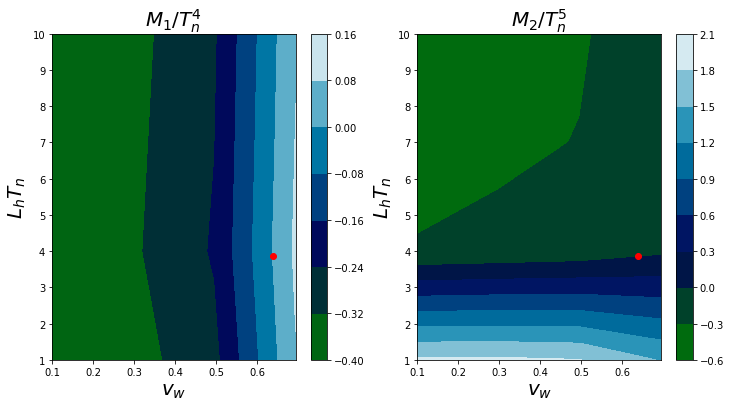

alpha =0.015293052871953292, alpha_N=0.026714110314717834


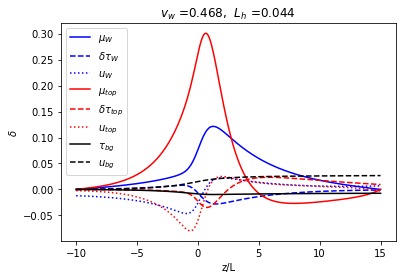

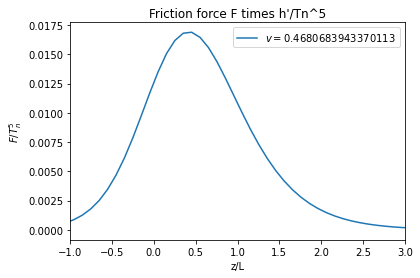

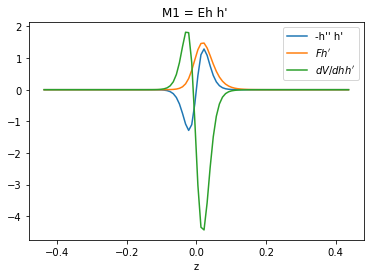

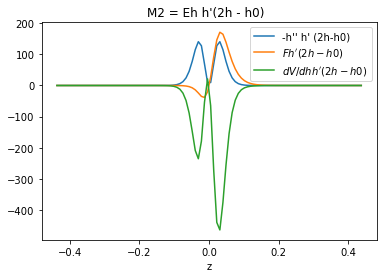

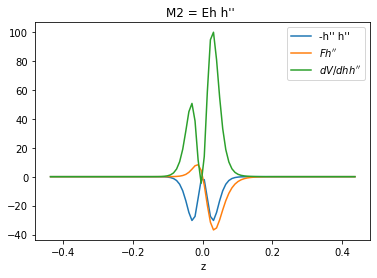

Potential parameters are given by 
 
mus2= 6482.407855051846 muh2= -158236.90497301175 lamh= 0.16994480640169554 lams= 0.3842771373872639 lammix= 2.531968347242033 

Model parameters are 

ms= 384.8964875825502 theta= 0.19460295112030107 muhs= -929.457577262217 u= 326.76237045339377 mu3= 76.74679929437062 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [246.20000441 326.76237169] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.......................................................................................
Tracing phase starting at x = [-7.77826810e-07  2.61748139e+02] ; t = 121.22512705746107
Tracing minimum down
traceMinimum t0 = 121.225
.................
Tracing minimum up
traceMinimum t0 = 121.225
.........................................................................................................................................................
Tunneling from phase 1 to phase 0 at T=0
high_vev = [5.15579552e-06 2.61023111e+02]
low_vev =

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091898,   T_+=89.185461
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6867075136378965, 'Lh': 0.011227930987969799, 'dh': 0, 'h0': 227.1177285553028, 'Ls': 0.011227930987969799, 'ds': 0, 'shigh': 261.7136239537406, 'slow': 323.09180786636233}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6867075136378965, 'Lh': 0.011227930987969799, 'dh': 0, 'h0': 227.1177285553028, 'Ls': 0.011227930987969799, 'ds': 0, 'shigh': 261.7136239537406, 'slow': 323.09180786636233}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


alpha+ = 0.012361
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.479804, T+=107.903099
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=204.148201, slow=318.139295, shigh=261.772000
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.6947278458350615, 'Lh': 0.011227930987969799, 'dh': 0, 'h0': 204.14820138006397, 'Ls': 0.011227930987969799, 'ds': 0, 'shigh': 261.7719998322867, 'slow': 318.1392952119213}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6867075136378965, 'Lh': 0.011227930987969799, 'dh': 0, 'h0': 227.1177285553028, 'Ls': 0.011227930987969799, 'ds': 0, 'shigh': 261.7136239537406, 'slow': 323.09180786636233}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012361
integrating the deflagration component 
........
 Finding velocity and temperature in front of

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.011,  ds=-0.016
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.011227930987969799, 'dh': 0, 'h0': 226.87306628841932, 'Ls': 0.011335858819556144, 'ds': -0.016014601790186486, 'shigh': 261.71432280451256, 'slow': 323.0711586564005}
Solving Boltzmann transport equations for vw=0.09189809252202585, Lh=0.011227930987969799, T+=89.1854611597018
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has b

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:383: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.045,  ds=-0.014
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.044911723951879194, 'dh': 0, 'h0': 226.83155621141051, 'Ls': 0.044911712887290296, 'ds': -0.01426703662880465, 'shigh': 261.71432280451256, 'slow': 323.0711586564005}
Solving Boltzmann transport equations for vw=0.09189809252202585, Lh=0.044911723951879194, T+=89.1854611597018
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has be

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:464: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6867075136378965, 'Lh': 0.011227930987969799, 'dh': 0, 'h0': 227.1177285553028, 'Ls': 0.011227930987969799, 'ds': 0, 'shigh': 261.7136239537406, 'slow': 323.09180786636233}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.091898,   T_+=89.185461
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=227.015847, slow=323.071159, shigh=261.714323
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.11227930987969799, 'dh': 0, 'h0': 227.01584741343024, 'Ls': 0.011227930987969799, 'ds': 0, 'shigh': 261.71432280451256, 'slow': 323.0711586564005}
Solving Boltzmann transport equations for vw=0.09189809252202585, Lh=0.11227930987969799, T+=89.1854611597018
.......
Initializing interpolation for damping term $A^{-1}\

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


........
 Finding velocity and temperature in front of the wall:
v_+=0.270434,   T_+=90.106544
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=226.231148, slow=322.911691, shigh=261.719583
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29824261527835383, 'Lh': 0.011227930987969799, 'dh': 0, 'h0': 226.23114757878608, 'Ls': 0.011227930987969799, 'ds': 0, 'shigh': 261.7195829045195, 'slow': 322.91169059586156}
Solving Boltzmann transport equations for vw=0.2704341394631522, Lh=0.011227930987969799, T+=90.106543707518
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equat

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6867075136378965, 'Lh': 0.011227930987969799, 'dh': 0, 'h0': 227.1177285553028, 'Ls': 0.011227930987969799, 'ds': 0, 'shigh': 261.7136239537406, 'slow': 323.09180786636233}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.270434,   T_+=90.106544
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=226.231148, slow=322.911691, shigh=261.719583
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29824261527835383, 'Lh': 0.11227930987969799, 'dh': 0, 'h0': 226.23114757878608, 'Ls': 0.011227930987969799, 'ds': 0, 'shigh': 261.7195829045195, 'slow': 322.91169059586156}
Solving Boltzmann transport equati

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6867075136378965, 'Lh': 0.011227930987969799, 'dh': 0, 'h0': 227.1177285553028, 'Ls': 0.011227930987969799, 'ds': 0, 'shigh': 261.7136239537406, 'slow': 323.09180786636233}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.423539,   T_+=93.386613
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=223.220541, slow=322.293514, shigh=261.

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.012,  ds=0.038
New guess is given by: 
 ...........
{'vw': 0.6947278458350615, 'Lh': 0.011227930987969799, 'dh': 0, 'h0': 202.92874913591083, 'Ls': 0.011608476635657755, 'ds': 0.03797859559068119, 'shigh': 261.7719998322867, 'slow': 318.1392952119213}
Solving Boltzmann transport equations for vw=0.4798041928664171, Lh=0.011227930987969799, T+=107.9030991190844
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=203.58916402015174.

guess dict has been updated   
......................
h0=203.589
New guess is given by: 
 ...........
{'vw': 0.6947278458350615, 'Lh': 0.11227930987969799, 'dh': 0, 'h0': 203.58916402015174, 'Ls': 0.011227930987969799, 'ds': 0, 'shigh': 261.7719998322867, 'slow': 318.1392952119213}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.112,  ds=0.035
New guess is given by: 
 ...........
{'vw': 0.6947278458350615, 'Lh': 0.11227930987969799, 'dh': 0, 'h0': 203.58916402015174, 'Ls': 0.11227929692056927, 'ds': 0.03512127127198157, 'shigh': 261.7719998322867, 'slow': 318.1392952119213}
Solving Boltzmann transport equations for vw=0.479804192866

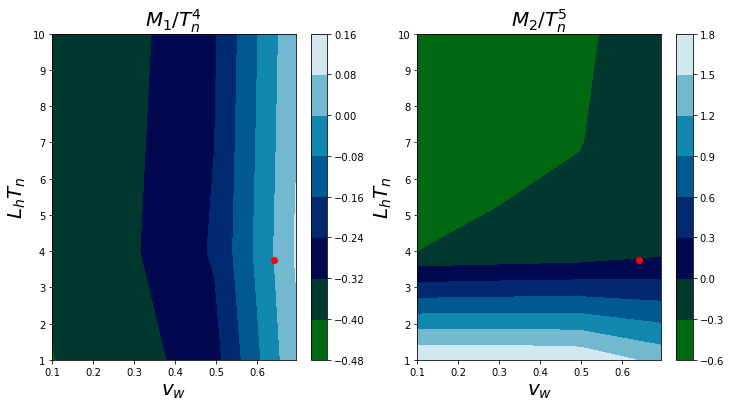

alpha =0.015075052557953224, alpha_N=0.026630733047838605


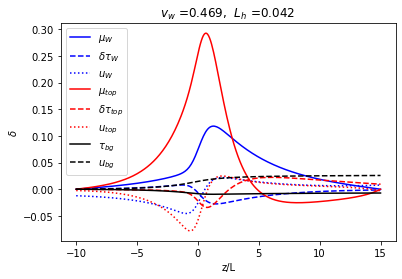

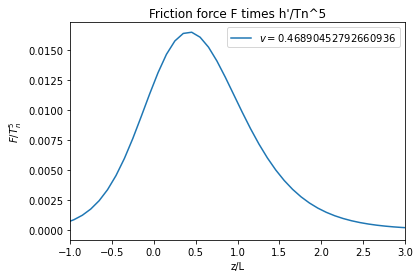

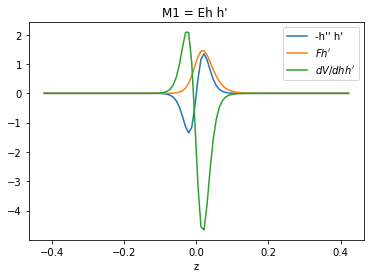

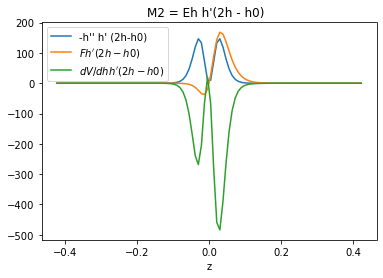

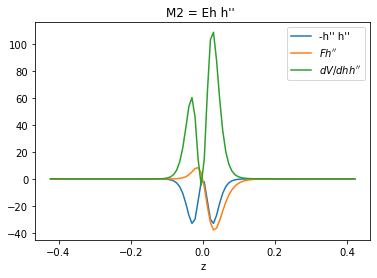

Potential parameters are given by 
 
mus2= 109813.98089391468 muh2= -118567.4112721862 lamh= 0.3560225513124628 lams= 6.422283686573344 lammix= 1.0822250000191744 

Model parameters are 

ms= 790.6646437731963 theta= -0.2140925172249786 muhs= 753.3298913840927 u= -221.17524779118682 mu3= -605.5212925431317 

Model is theoretically consistent 

isEWSB=True 

Tracing phase starting at x = [ 246.1999923  -221.17524556] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
..........................................................................................................................................
Tracing phase starting at x = [ 1.05009603e-05 -1.81740866e+02] ; t = 117.01940940948514
Tracing minimum down
traceMinimum t0 = 117.019
.......................
Tracing minimum up
traceMinimum t0 = 117.019
...........................................................................................................................................................................................

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.091968,   T_+=85.931593
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6806244173323909, 'Lh': 0.01165295171365859, 'dh': 0, 'h0': 229.61955815484282, 'Ls': 0.01165295171365859, 'ds': 0, 'shigh': -181.04507185947864, 'slow': -217.68603804817815}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6806244173323909, 'Lh': 0.01165295171365859, 'dh': 0, 'h0': 229.61955815484282, 'Ls': 0.01165295171365859, 'ds': 0, 'shigh': -181.04507185947864, 'slow': -217.68603804817815}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


alpha+ = 0.012288
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.480109, T+=103.893831
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6806244173323909, 'Lh': 0.01165295171365859, 'dh': 0, 'h0': 229.61955815484282, 'Ls': 0.01165295171365859, 'ds': 0, 'shigh': -181.04507185947864, 'slow': -217.68603804817815}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.013801
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.473900, T+=100.920998
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6806244173323909, 'Lh': 0.01165295171365859, 'dh': 0, 'h0': 229.61955815484282, 'Ls': 0.01165295171365859, 'ds': 0, 'shigh': -181.04507185947864, 'slow': -217.68603804817815}
This 

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.416659,   T_+=89.584066
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6806244173323909, 'Lh': 0.01165295171365859, 'dh': 0, 'h0': 229.61955815484282, 'Ls': 0.01165295171365859, 'ds': 0, 'shigh': -181.04507185947864, 'slow': -217.68603804817815}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.396780,   T_+=88.825372
init_h0_s0 WAS NOT SUCCESSFUL 
 ...................... 
......................
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6806244173323909, 'Lh': 0.01165295171365859, 'dh': 0, 'h0': 229.61955815484282, 'Ls': 0.01165295171365859, 'ds': 0, 'shigh': -181.04507185947864, 'slow': -217.68603804817815}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and tem

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:364: RuntimeWarning: invalid value encountered in sqrt


isEWSB=True 

Tracing phase starting at x = [246.19999842 197.35235539] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
......................................................................................
Tracing phase starting at x = [9.81110476e-06 1.59367349e+02] ; t = 118.13804203206476
Tracing minimum down
traceMinimum t0 = 118.138
............................
Tracing minimum up
traceMinimum t0 = 118.138
............................................................................................................................................................................................................................................................................
Tunneling from phase 1 to phase 0 at T=0
high_vev = [7.15672128e-06 1.56995452e+02]
low_vev = [246.1999955  197.35235529]
Path deformation converged. 19 steps. fRatio = 1.43846e-02
Path deformation converged. 1 steps. fRatio = 5.31078e-02
Tunneling from phase 1 to phase 0 at T=52.7643
high_vev = [9.75174854e-05 1.

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.092048,   T_+=86.210024
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6804443815688486, 'Lh': 0.011615164735070092, 'dh': 0, 'h0': 229.621324597964, 'Ls': 0.011615164735070092, 'ds': 0, 'shigh': 158.3537868261452, 'slow': 193.85168020540178}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6804443815688486, 'Lh': 0.011615164735070092, 'dh': 0, 'h0': 229.621324597964, 'Ls': 0.011615164735070092, 'ds': 0, 'shigh': 158.3537868261452, 'slow': 193.85168020540178}
This is a Jouguet detonation
Finding alpha+ 
...........


/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:159: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:364: RuntimeWarning: invalid value encountered in sqrt


alpha+ = 0.012205
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.480459, T+=104.147272
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=209.920657, slow=189.754284, shigh=158.914966
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.6937810775075087, 'Lh': 0.011615164735070092, 'dh': 0, 'h0': 209.9206566239346, 'Ls': 0.011615164735070092, 'ds': 0, 'shigh': 158.91496571351368, 'slow': 189.75428387683957}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6804443815688486, 'Lh': 0.011615164735070092, 'dh': 0, 'h0': 229.621324597964, 'Ls': 0.011615164735070092, 'ds': 0, 'shigh': 158.3537868261452, 'slow': 193.85168020540178}
This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.012205
integrating the deflagration component 
........
 Finding velocity and temperature in front of

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:382: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.010,  ds=0.314
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.011615164735070092, 'dh': 0, 'h0': 229.49010944294352, 'Ls': 0.010190513396793532, 'ds': 0.3144285866199829, 'shigh': 158.35721493336968, 'slow': 193.83342738976114}
Solving Boltzmann transport equations for vw=0.0920475435276753, Lh=0.011615164735070092, T+=86.21002370432934
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:383: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.081,  ds=0.257
New guess is given by: 
 ...........
{'vw': 0.1, 'Lh': 0.08130615314549064, 'dh': 0, 'h0': 229.46368465596407, 'Ls': 0.08130614873308481, 'ds': 0.2572386612509294, 'shigh': 158.35721493336968, 'slow': 193.83342738976114}
Solving Boltzmann transport equations for vw=0.0920475435276753, Lh=0.08130615314549064, T+=86.21002370432934
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been ad

/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.270645,   T_+=87.083214
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=228.864866, slow=193.693148, shigh=158.383226
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29792702583583625, 'Lh': 0.011615164735070092, 'dh': 0, 'h0': 228.86486639096944, 'Ls': 0.011615164735070092, 'ds': 0, 'shigh': 158.38322588570733, 'slow': 193.69314822308132}
Solving Boltzmann transport equations for vw=0.2706451877038897, Lh=0.011615164735070092, T+=87.08321439004517
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport eq

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6804443815688486, 'Lh': 0.011615164735070092, 'dh': 0, 'h0': 229.621324597964, 'Ls': 0.011615164735070092, 'ds': 0, 'shigh': 158.3537868261452, 'slow': 193.85168020540178}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.270645,   T_+=87.083214
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=228.864866, slow=193.693148, shigh=158.383226
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.29792702583583625, 'Lh': 0.11615164735070092, 'dh': 0, 'h0': 228.86486639096944, 'Ls': 0.011615164735070092, 'ds': 0, 'shigh': 158.38322588570733, 'slow': 193.69314822308132}
Solving Boltzmann transport equati

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.6804443815688486, 'Lh': 0.011615164735070092, 'dh': 0, 'h0': 229.621324597964, 'Ls': 0.011615164735070092, 'ds': 0, 'shigh': 158.3537868261452, 'slow': 193.85168020540178}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.424147,   T_+=90.200291
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=226.293948, slow=193.155103, shigh=158.4

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.010,  ds=0.341
New guess is given by: 
 ...........
{'vw': 0.6937810775075087, 'Lh': 0.011615164735070092, 'dh': 0, 'h0': 209.50987587284465, 'Ls': 0.010227202340352766, 'ds': 0.3405982037576223, 'shigh': 158.91496571351368, 'slow': 189.75428387683957}
Solving Boltzmann transport equations for vw=0.4804589576444499, Lh=0.011615164735070092, T+=104.14727194743227
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v

Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=209.73211951958268.

guess dict has been updated   
......................
h0=209.732
New guess is given by: 
 ...........
{'vw': 0.6937810775075087, 'Lh': 0.11615164735070092, 'dh': 0, 'h0': 209.73211951958268, 'Ls': 0.011615164735070092, 'ds': 0, 'shigh': 158.91496571351368, 'slow': 189.75428387683957}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.120,  ds=0.248
New guess is given by: 
 ...........
{'vw': 0.6937810775075087, 'Lh': 0.11615164735070092, 'dh': 0, 'h0': 209.73211951958268, 'Ls': 0.12011466171922532, 'ds': 0.24816059899872608, 'shigh': 158.91496571351368, 'slow': 189.75428387683957}
Solving Boltzmann transport equations for vw=0.48045895

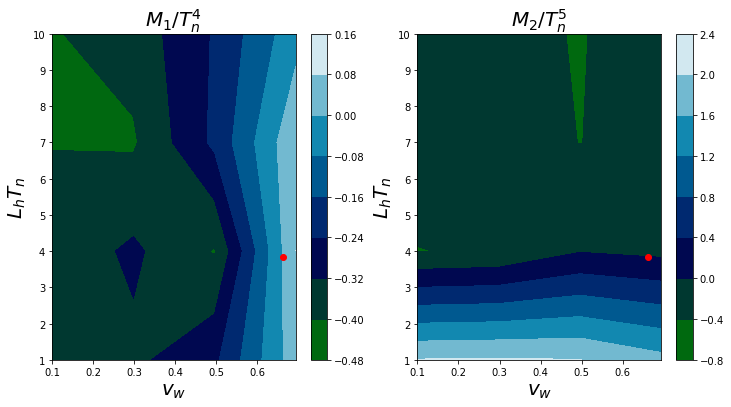

alpha =0.013806447785442308, alpha_N=0.026136445513871735


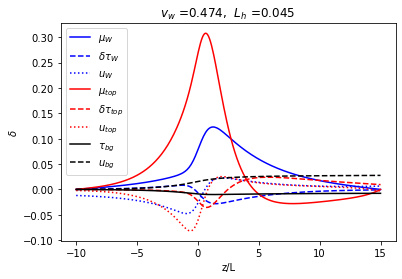

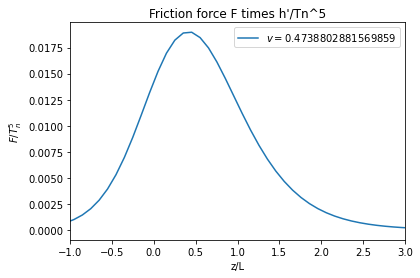

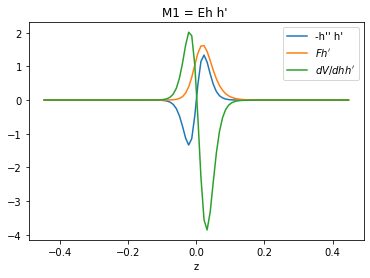

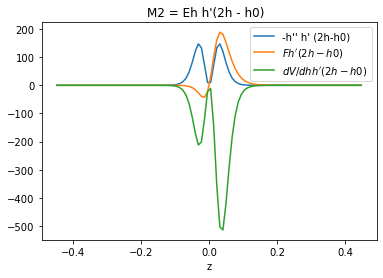

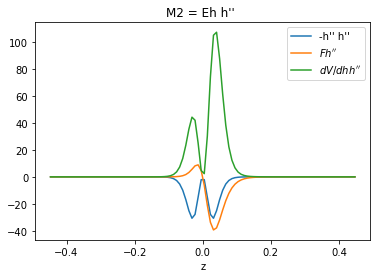

In [5]:
df=pd.read_csv("SCANS/On_Shell_STRONG.csv",index_col=[0]).sort_values("alpha_max").drop_duplicates()
df=df[df.alpha_max>2.44e-2]
df=df[df.num_FOPT==1]
df=df[df["v_calculable_0"]]

my_dicts=[]
didnt_work_list=[]
for modind in range(1,len(df)+1):
    modi=-modind
    dict_out=dict(df.iloc[modi])
    m=model1(ms = df.iloc[modi].ms, theta =df.iloc[modi].theta, muhs = df.iloc[modi].muhs,
             u = df.iloc[modi].u, mu3 =df.iloc[modi].mu3)
    m.print_couplings()
    thbool=m.theory_consistent()
    EWSBbool=m.isEWSB()
    if thbool==True and EWSBbool==True:
        try:
            alltrans=m.findAllTransitions()
            some_bubble=bubble(m)
            some_bubble.test_analytic_formula()
            some_bubble.initial_guess()
            some_bubble=bubble(m)
            some_bubble.initial_guess()
            LT_max=10
            LT_min=1
            some_bubble.grid_scan((.1,0.73,4),(LT_min/some_bubble.T,LT_max/some_bubble.T,4))
            potential_plot( modi,df,clevs=50, myN =170, index_trans=0)
            some_bubble.find_min_grid()
            some_bubble.print_gridmap()
            dict_out.update(some_bubble.guess)
            dict_out.update(some_bubble.hydro_dict)
            some_bubble.my_print()
            some_bubble.print_friction()
            some_bubble.print_contribs()
            dict_out.update(some_bubble.guess)
            dict_out.update(some_bubble.hydro_dict)
            my_dicts.append(dict_out)
            
        except:
            print("modi=",modi," did not work")
            didnt_work_list.append(modi)
            continue

